In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score
from PIL import Image
import random

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create subsets for each task
def get_class_indices(dataset, classes):
    indices = [i for i, (x, y) in enumerate(dataset) if y in classes]
    return indices

initial_classes = [0, 1, 2, 3]
subsequent_classes = [4, 5, 6]
final_classes = [7, 8, 9]

train_indices_1 = get_class_indices(train_dataset, initial_classes)
test_indices_1 = get_class_indices(test_dataset, initial_classes)
train_indices_2 = get_class_indices(train_dataset, subsequent_classes)
test_indices_2 = get_class_indices(test_dataset, subsequent_classes)
train_indices_3 = get_class_indices(train_dataset, final_classes)
test_indices_3 = get_class_indices(test_dataset, final_classes)

# Function to create training and validation sets
def create_train_val_split(indices, val_split=0.2):
    total_size = len(indices)
    val_size = int(total_size * val_split)
    train_size = total_size - val_size
    train_indices, val_indices = random_split(indices, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    return list(train_indices), list(val_indices)

# Create training, validation, and test sets for each task
train_indices_1, val_indices_1 = create_train_val_split(train_indices_1)
train_indices_2, val_indices_2 = create_train_val_split(train_indices_2)
train_indices_3, val_indices_3 = create_train_val_split(train_indices_3)

# Create DataLoaders for Task 1
train_loader_1 = DataLoader(Subset(train_dataset, train_indices_1), batch_size=64, shuffle=True)
val_loader_1 = DataLoader(Subset(train_dataset, val_indices_1), batch_size=64, shuffle=False)
test_loader_1 = DataLoader(Subset(test_dataset, test_indices_1), batch_size=64, shuffle=False)

# Create DataLoaders for Task 2
train_loader_2 = DataLoader(Subset(train_dataset, train_indices_2), batch_size=64, shuffle=True)
val_loader_2 = DataLoader(Subset(train_dataset, val_indices_2), batch_size=64, shuffle=False)
test_loader_2 = DataLoader(Subset(test_dataset, test_indices_2), batch_size=64, shuffle=False)

# Create DataLoaders for Task 3
train_loader_3 = DataLoader(Subset(train_dataset, train_indices_3), batch_size=64, shuffle=True)
val_loader_3 = DataLoader(Subset(train_dataset, val_indices_3), batch_size=64, shuffle=False)
test_loader_3 = DataLoader(Subset(test_dataset, test_indices_3), batch_size=64, shuffle=False)

# Verification
print(f"Task 1: Train size = {len(train_loader_1.dataset)}, Val size = {len(val_loader_1.dataset)}, Test size = {len(test_loader_1.dataset)}")
print(f"Task 2: Train size = {len(train_loader_2.dataset)}, Val size = {len(val_loader_2.dataset)}, Test size = {len(test_loader_2.dataset)}")
print(f"Task 3: Train size = {len(train_loader_3.dataset)}, Val size = {len(val_loader_3.dataset)}, Test size = {len(test_loader_3.dataset)}")


Task 1: Train size = 19804, Val size = 4950, Test size = 4157
Task 2: Train size = 13745, Val size = 3436, Test size = 2832
Task 3: Train size = 14452, Val size = 3613, Test size = 3011


In [2]:
from collections import Counter
from scipy.spatial.distance import cosine
from scipy.special import rel_entr
import numpy as np

# Function to compute class distributions
def get_class_distribution(dataloader, num_classes=10):
    class_counts = Counter()
    for _, targets in dataloader:
        class_counts.update(targets.numpy())
    # Create a probability distribution
    total_count = sum(class_counts.values())
    probabilities = np.zeros(num_classes)
    for cls, count in class_counts.items():
        probabilities[cls] = count / total_count
    return probabilities

# Function to calculate cosine similarity
def calculate_cosine_similarity(dist1, dist2):
    return 1 - cosine(dist1, dist2)

# Function to calculate KL divergence
def calculate_kl_divergence(dist1, dist2):
    return sum(rel_entr(dist1, dist2))

# Get distributions for each dataset
train_dist_1 = get_class_distribution(train_loader_1)
train_dist_2 = get_class_distribution(train_loader_2)
train_dist_3 = get_class_distribution(train_loader_3)

val_dist_1 = get_class_distribution(val_loader_1)
val_dist_2 = get_class_distribution(val_loader_2)
val_dist_3 = get_class_distribution(val_loader_3)

test_dist_1 = get_class_distribution(test_loader_1)
test_dist_2 = get_class_distribution(test_loader_2)
test_dist_3 = get_class_distribution(test_loader_3)

# Example: Cosine similarity between train distributions of Task 1 and Task 2
cosine_similarity_train_1_2 = calculate_cosine_similarity(train_dist_1, train_dist_2)
print(f"Cosine Similarity (Train Task 1 vs. Train Task 2): {cosine_similarity_train_1_2:.4f}")

# Example: KL divergence between train distributions of Task 1 and Task 2
kl_divergence_train_1_2 = calculate_kl_divergence(train_dist_1, train_dist_2)
print(f"KL Divergence (Train Task 1 vs. Train Task 2): {kl_divergence_train_1_2:.4f}")

# Similarly, compute for other combinations of datasets
cosine_similarity_train_2_3 = calculate_cosine_similarity(train_dist_2, train_dist_3)
kl_divergence_train_2_3 = calculate_kl_divergence(train_dist_2, train_dist_3)

cosine_similarity_train_1_3 = calculate_cosine_similarity(train_dist_1, train_dist_3)
kl_divergence_train_1_3 = calculate_kl_divergence(train_dist_1, train_dist_3)

print(f"Cosine Similarity (Train Task 2 vs. Train Task 3): {cosine_similarity_train_2_3:.4f}")
print(f"KL Divergence (Train Task 2 vs. Train Task 3): {kl_divergence_train_2_3:.4f}")

print(f"Cosine Similarity (Train Task 1 vs. Train Task 3): {cosine_similarity_train_1_3:.4f}")
print(f"KL Divergence (Train Task 1 vs. Train Task 3): {kl_divergence_train_1_3:.4f}")


Cosine Similarity (Train Task 1 vs. Train Task 2): 0.0000
KL Divergence (Train Task 1 vs. Train Task 2): inf
Cosine Similarity (Train Task 2 vs. Train Task 3): 0.0000
KL Divergence (Train Task 2 vs. Train Task 3): inf
Cosine Similarity (Train Task 1 vs. Train Task 3): 0.0000
KL Divergence (Train Task 1 vs. Train Task 3): inf


In [3]:
def get_num_classes_from_loader(loader):
    """
    Extract the number of unique classes from a DataLoader's dataset.
    """
    # Access the underlying dataset
    dataset = loader.dataset
    if isinstance(dataset, Subset):
        # Extract targets from the original dataset using indices
        targets = [dataset.dataset.targets[i] for i in dataset.indices]
    else:
        # Directly use the dataset's targets
        targets = dataset.targets
    return len(set(targets))


In [4]:
class SimpleNeuralNet(nn.Module):
    def __init__(self, input_dim=28*28, output_dim=10):
        super(SimpleNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, output_dim)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
class SimpleNN(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=256, output_size=10):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [6]:
import torch.nn.functional as F

class EnhancedNeuralNet(nn.Module):
    def __init__(self, input_dim=28*28, output_dim=10):
        super(EnhancedNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, output_dim)
        self.dropout = nn.Dropout(0.5)  # Dropout to prevent overfitting
        self.batch_norm1 = nn.BatchNorm1d(1024)
        self.batch_norm2 = nn.BatchNorm1d(1024)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.batch_norm1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.batch_norm2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

class ClassifierWeightedNet(nn.Module):
    def __init__(self, input_dim=28*28, feature_dim=512):
        super(ClassifierWeightedNet, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, feature_dim),
            nn.ReLU()
        )
        # Start with an empty classifier layer
        self.classifier = nn.Linear(feature_dim, 0, bias=False)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        features = self.feature_extractor(x)
        outputs = self.classifier(features)
        return outputs

    def expand_classifier(self, new_classes):
        """
        Dynamically add weights for new classes.
        """
        with torch.no_grad():
            # Get current classifier weights
            old_weights = self.classifier.weight.data
            num_new_classes = len(new_classes)
            
            # Create new weights for additional classes
            new_weights = torch.zeros((num_new_classes, old_weights.size(1)))
            
            # Update the classifier layer with expanded weights
            self.classifier = nn.Linear(old_weights.size(1), old_weights.size(0) + num_new_classes, bias=False)
            self.classifier.weight.data[:old_weights.size(0)] = old_weights
            self.classifier.weight.data[old_weights.size(0):] = new_weights

# Training step
def train_step(model, optimizer, criterion, data_loader, current_classes, class_mapping):
    model.train()
    for x, y in data_loader:
        optimizer.zero_grad()
        outputs = model(x)
        
        # Map labels to the indices of the current classes
        filtered_labels = torch.tensor([class_mapping[label.item()] for label in y])
        
        # Filter the outputs for the current classes
        filtered_outputs = outputs[:, current_classes]
        
        # Compute loss and backpropagate
        loss = criterion(filtered_outputs, filtered_labels)
        loss.backward()
        optimizer.step()

# Example training loop
def class_iterated_training(model, tasks, input_dim=28*28, feature_dim=512):
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    
    # Initialize a mapping for classes seen so far
    class_mapping = {}
    current_classes = []

    for task_id, (data_loader, new_classes) in enumerate(tasks):
        # Expand the classifier for new classes
        model.expand_classifier(new_classes)
        
        # Update the class mapping
        for i, cls in enumerate(new_classes):
            class_mapping[cls] = len(current_classes) + i
            
        # Update the current class indices
        current_classes.extend(range(len(current_classes), len(current_classes) + len(new_classes)))
        
        # Train on the current task
        train_step(model, optimizer, criterion, data_loader, current_classes, class_mapping)


In [8]:
def train(model, loader, optimizer, criterion, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, target in loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(loader)}')

# Define evaluation function with additional metrics
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            predictions = torch.argmax(output, dim=1)
            all_targets.extend(target.numpy())
            all_predictions.extend(predictions.numpy())

    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_predictions, average='weighted', zero_division=0)
    kappa = cohen_kappa_score(all_targets, all_predictions)
    
    return {
        'loss': total_loss / len(loader),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'kappa': kappa
    }


In [9]:
def evaluate_old(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for data, target in loader:  # Get data, target, and task_id
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            predictions = torch.argmax(output, dim=1)
            all_targets.extend(target.numpy())
            all_predictions.extend(predictions.numpy())

    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_predictions, average='weighted', zero_division=0)
    kappa = cohen_kappa_score(all_targets, all_predictions)

    return accuracy, precision, recall, kappa

In [10]:
class OnlineEWC:
    def __init__(self, model, dataloader):
        """
        Online EWC implementation.
        Args:
            model: Neural network model.
            dataloader: DataLoader for the current task.
        """
        self.model = model
        self.dataloader = dataloader
        self.fisher_matrix = {}
        self.optimal_params = {}

    def update_fisher_matrix(self):
        """
        Update the Fisher matrix using the online method.
        """
        self.model.eval()
        fisher_diagonal = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
        
        for i, (data, target) in enumerate(self.dataloader, 1):
            self.model.zero_grad()
            output = self.model(data)
            loss = F.nll_loss(F.log_softmax(output, dim=1), target)
            loss.backward()

            # Update Fisher diagonal iteratively
            for n, p in self.model.named_parameters():
                if p.grad is not None:
                    fisher_diagonal[n] += (p.grad ** 2 - fisher_diagonal[n]) / i
        
        # Update Fisher matrix with the new Fisher diagonal values
        for n in fisher_diagonal:
            if n in self.fisher_matrix:
                self.fisher_matrix[n] += fisher_diagonal[n]
            else:
                self.fisher_matrix[n] = fisher_diagonal[n]

    def store_optimal_params(self):
        """
        Store a copy of the model's current parameters as the optimal parameters for the current task.
        """
        self.optimal_params = {n: p.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}

    def penalty(self, model):
        """
        Calculate the EWC penalty based on the Fisher matrix and optimal parameters.
        """
        penalty = 0.0
        for n, p in model.named_parameters():
            if p.requires_grad and n in self.fisher_matrix:
                penalty += (self.fisher_matrix[n] * (p - self.optimal_params[n]) ** 2).sum()
        return penalty


In [11]:
def train_with_ewc(model, optimizer, dataloaders, ewc=None, lambda_ewc=0.1, epochs=5):
    """
    Train the model with or without EWC penalty.
    
    Args:
        model: Neural network model to train.
        optimizer: Optimizer for training.
        dataloaders: Dictionary containing 'train' and optionally 'val' dataloaders.
        ewc: Instance of the EWC class, or None if not using EWC.
        lambda_ewc: Importance of the EWC penalty (default is 0.1).
        epochs: Number of epochs to train.
    """
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, targets in dataloaders['train']:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Add EWC penalty if applicable
            if ewc is not None:
                ewc_penalty = ewc.penalty(model)
                loss += lambda_ewc * ewc_penalty
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(dataloaders['train'])}")


In [12]:
def train_with_ewc_with_patience(model, loader, ewc, optimizer, criterion, epochs=10, patience=5):
    """
    Trains the model with EWC regularization, including early stopping.

    Args:
        model (torch.nn.Module): The model to train.
        loader (torch.utils.data.DataLoader): The data loader for training.
        ewc (EWC): The EWC object containing penalty information.
        optimizer (torch.optim.Optimizer): The optimizer to use.
        criterion (torch.nn.Module): The loss function.
        epochs (int): The maximum number of epochs to train.
        patience (int): The number of epochs to wait for improvement before stopping early.

    Returns:
        None
    """
    model.train()
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        total_loss = 0
        total_penalty = 0
        for data, target in loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            penalty = ewc.penalty()
            total_loss += loss.item()
            total_penalty += penalty.item()
            loss += penalty
            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(loader)
        avg_penalty = total_penalty / len(loader)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Penalty: {avg_penalty:.4f}')

        # Early stopping mechanism
        if avg_loss < best_loss:
            best_loss = avg_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs.')
            break


In [13]:
# Training and Evaluation Functions
def train_with_patience(model, loader, optimizer, criterion, epochs=10, patience=5):
    model.train()
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        total_loss = 0
        for data, target in loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}')

        # Check for early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            epochs_no_improve = 0
            # Save the best model (optional)
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs.')
            break

    # Load the best model state (optional)
    model.load_state_dict(best_model_state)

In [14]:
def train_with_patience(model, data_loader, optimizer, criterion, epochs=1, patience=5, current_classes=None):
    model.train()
    for epoch in range(epochs):
        for x, y in data_loader:
            optimizer.zero_grad()
            outputs = model(x)
            # Select only the current task's outputs
            task_outputs = outputs[:, current_classes]
            loss = criterion(task_outputs, y)
            loss.backward()
            optimizer.step()

from sklearn.metrics import precision_score, recall_score, cohen_kappa_score
import torch

def evaluate(model, test_loader, criterion, current_classes):
    """
    Evaluate the model on the given test_loader.

    Args:
        model: The neural network being evaluated.
        test_loader: DataLoader containing the test dataset.
        criterion: Loss function.
        current_classes: List of class indices relevant to the current task.

    Returns:
        Tuple containing accuracy, precision, recall, and kappa score.
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct = 0
    total = 0

    all_targets = []
    all_preds = []

    with torch.no_grad():
        for data, targets in test_loader:
            # Forward pass
            outputs = model(data)

            # Dynamically mask irrelevant outputs (only keep current task classes)
            outputs = outputs[:, current_classes]

            # Adjust targets to align with the current task's class indices
            task_targets = torch.tensor(
                [current_classes.index(t.item()) for t in targets if t.item() in current_classes]
            )

            # Compute loss
            loss = criterion(outputs, task_targets)
            total_loss += loss.item()

            # Get predictions
            _, preds = torch.max(outputs, 1)
            correct += (preds == task_targets).sum().item()
            total += task_targets.size(0)

            # Append to lists for metric computation
            all_targets.extend(task_targets.numpy())
            all_preds.extend(preds.numpy())

    # Compute evaluation metrics
    accuracy = correct / total if total > 0 else 0.0
    precision = precision_score(all_targets, all_preds, average="macro", zero_division=0)
    recall = recall_score(all_targets, all_preds, average="macro", zero_division=0)
    kappa = cohen_kappa_score(all_targets, all_preds)

    return accuracy, precision, recall, kappa





# def train_with_ewc(model, train_loader, ewc, optimizer, criterion, epochs=1, patience=5):
#     model.train()
#     best_loss = float('inf')
#     no_improve_epochs = 0

#     for epoch in range(epochs):
#         total_loss = 0.0
#         correct = 0
#         total = 0

#         for data, targets in train_loader:
#             data, targets = data.to(next(model.parameters()).device), targets.to(next(model.parameters()).device)

#             # Forward pass
#             optimizer.zero_grad()
#             outputs = model(data)
#             outputs = model.mask_outputs(outputs, model.current_classes)

#             # Compute task-specific and EWC losses
#             task_loss = criterion(outputs, targets)
#             ewc_loss = ewc.penalty(model).detach() if ewc else 0.0  # Detach EWC penalty
#             loss = task_loss + ewc_loss

#             # Backward pass
#             loss.backward()  # No retain_graph needed
#             optimizer.step()

#             total_loss += loss.item()

#             # Accuracy calculation
#             _, preds = torch.max(outputs, 1)
#             correct += (preds == targets).sum().item()
#             total += targets.size(0)

#         # Per-epoch statistics
#         epoch_loss = total_loss / len(train_loader)
#         epoch_accuracy = correct / total
#         print(f"Epoch {epoch + 1}/{epochs}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_accuracy:.4f}")

#         # Early stopping
#         if epoch_loss < best_loss:
#             best_loss = epoch_loss
#             no_improve_epochs = 0
#         else:
#             no_improve_epochs += 1
#             if no_improve_epochs >= patience:
#                 print("Early stopping due to no improvement in loss.")
#                 break





In [326]:
import json
# Initialize model, optimizer, and criterion
# Initialize storage for results
results = {
    "untrained_A": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "initial_A": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_B_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "C_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_C_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_after_C_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_B_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "C_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_C_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_after_C_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []}
}

results_val = {
    "initial_A": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_B_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "C_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_C_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_after_C_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_B_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "C_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_C_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_after_C_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []}
}

# Store per-epoch values for charting the training of Task 2 and Task 3
epoch_stats = {
    "Initial": {"accuracy": [], "loss": []},
    "ewc": {
        "A_during_A": [], "A_during_A_val": [], "A_during_B":[], "A_during_B_val": [], 
        "B_during_C": [], "A_during_C": [], "A_during_C_val": [], "B_during_C_val": [], 
        "task_B": [], "task_C": [], "val_task_C": [],"val_task_B": [],"task_A": [], "val_task_A": [],"C_during_A": [],"C_during_A_val": [],"C_during_B": [],
        "C_during_B_val": [],"B_during_A": [],"B_during_A_val": []
    },
    "no_ewc": {
        "A_during_A": [], "A_during_A_val": [], "A_during_B":[], "A_during_B_val": [], 
        "B_during_C": [], "A_during_C": [], "A_during_C_val": [], "B_during_C_val": [], 
        "task_B": [], "task_C": [], "val_task_C": [],"val_task_B": [],"task_A": [], "val_task_A": [],"C_during_A": [],"C_during_A_val": [],"C_during_B": [],
        "C_during_B_val": [],"B_during_A": [],"B_during_A_val": []
    }
}

epochs = 50
num_runs = 10
learning_rate = 0.000001

importance = 100

for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")

    #model = EnhancedNeuralNet(output_dim=10)
    model = SimpleNN()
    
    #model = ConvNet(output_dim=10)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    task_A_during_B_ewc_run = []
    task_A_during_B_no_ewc_run = []
    task_A_during_C_ewc_run = []
    task_A_during_C_no_ewc_run = []
    task_B_during_C_ewc_run = []
    task_B_during_C_no_ewc_run = []
    
    val_task_A_during_B_ewc_run = []
    val_task_A_during_B_no_ewc_run = []
    val_task_A_during_C_ewc_run = []
    val_task_A_during_C_no_ewc_run = []
    val_task_B_during_C_ewc_run = []
    val_task_B_during_C_no_ewc_run = []
    val_task_C_during_A_no_ewc_run = []
    task_C_during_A_no_ewc_run = []
    
    task_A_ewc_run = []
    task_A_no_ewc_run = []

    task_B_during_A_ewc_run = []
    task_B_during_A_ewc_run_val = []

    task_C_during_A_ewc_run = []
    task_C_during_A_ewc_run_val = []

    task_C_during_B_ewc_run = []
    task_C_during_B_ewc_run_val = []

    task_C_during_B_no_ewc_run = []
    val_task_C_during_B_no_ewc_run = []

    task_B_during_A_no_ewc_run = []
    task_B_during_A_no_ewc_run_val = []
    
    val_task_A_ewc_run = []
    val_task_A_no_ewc_run = []
    
    task_B_ewc_run = []
    task_B_no_ewc_run = []
    
    val_task_B_ewc_run = []
    val_task_B_no_ewc_run = []
    
    task_C_ewc_run = []
    task_C_no_ewc_run = []
    
    val_task_C_ewc_run = []
    val_task_C_no_ewc_run = []
    
    ewc = OnlineEWC(model, train_loader_1)
    # Train on initial classes
    for epoch in range(epochs):
        train_with_ewc(model, optimizer, {'train': train_loader_1, 'val': val_loader_1}, ewc=None, lambda_ewc=0, epochs=1)
        
        # Track performance on Task B
        accuracy_taskA, _, _, _ = evaluate(model, test_loader_1, criterion,initial_classes)
        print(f"Epoch {epoch + 1} - Task A performance during Task A (with EWC): {accuracy_taskA:.4f}")
        task_A_ewc_run.append(accuracy_taskA)
    
        # Track performance on Task B
        val_accuracy_taskA, _, _, _ = evaluate(model, val_loader_1, criterion,initial_classes)
        print(f"Epoch {epoch + 1} - Task A performance during Task A - validation set (with EWC): {val_accuracy_taskA:.4f}")
        val_task_A_ewc_run.append(val_accuracy_taskA)

        # Track performance on Task B
        accuracy_taskB_during_A, _, _, _ = evaluate(model, test_loader_2, criterion,subsequent_classes)
        print(f"Epoch {epoch + 1} - Task B durin gA(with EWC): {accuracy_taskB_during_A:.4f}")
        task_B_during_A_ewc_run.append(accuracy_taskB_during_A)
    
        # Track performance on Task B
        accuracy_taskB_during_A_val, _, _, _ = evaluate(model, val_loader_2, criterion,subsequent_classes)
        print(f"Epoch {epoch + 1} - Task B during A - validation set (with EWC): {accuracy_taskB_during_A_val:.4f}")
        task_B_during_A_ewc_run_val.append(accuracy_taskB_during_A_val)

        # Track performance on Task B
        accuracy_taskC_during_A, _, _, _ = evaluate(model, test_loader_3, criterion,final_classes)
        print(f"Epoch {epoch + 1} - Task C during A (with EWC): {accuracy_taskC_during_A:.4f}")
        task_C_during_A_ewc_run.append(accuracy_taskC_during_A)
    
        # Track performance on Task B
        accuracy_taskC_during_A_val, _, _, _ = evaluate(model, val_loader_3, criterion,final_classes)
        print(f"Epoch {epoch + 1} - Task C during A - validation set (with EWC): {accuracy_taskC_during_A_val:.4f}")
        task_C_during_A_ewc_run_val.append(accuracy_taskC_during_A_val)
    
    epoch_stats["ewc"]["A_during_A"].append(task_A_ewc_run)
    epoch_stats["ewc"]["A_during_A_val"].append(val_task_A_ewc_run)

    epoch_stats["ewc"]["B_during_A"].append(task_B_during_A_ewc_run)
    epoch_stats["ewc"]["B_during_A_val"].append(task_B_during_A_ewc_run_val)

    epoch_stats["ewc"]["C_during_A"].append(task_C_during_A_ewc_run)
    epoch_stats["ewc"]["C_during_A_val"].append(task_C_during_A_ewc_run_val)
    
    
    torch.save(model.state_dict(), 'initial_digits.pth')
    
    # Step 2: Evaluate Task A trained
    # Evaluate initial performance on Task A
    accuracy_taskA_initial, precision_taskA_initial, recall_taskA_initial, kappa_taskA_initial = evaluate(model, test_loader_1, criterion,initial_classes)
    print(f"Task A - Initial: Accuracy: {accuracy_taskA_initial:.4f}, Precision: {precision_taskA_initial:.4f}, Recall: {recall_taskA_initial:.4f}, Cohen's Kappa: {kappa_taskA_initial:.4f}")
    results["initial_A"]["accuracy"].append(accuracy_taskA_initial)
    results["initial_A"]["precision"].append(precision_taskA_initial)
    results["initial_A"]["recall"].append(recall_taskA_initial)
    results["initial_A"]["kappa"].append(kappa_taskA_initial)
    
    accuracy_taskA_initial_val, precision_taskA_initial_val, recall_taskA_initial_val, kappa_taskA_initial_val = evaluate(model, val_loader_1, criterion,initial_classes)
    print(f"Task A - Initial: Accuracy: {accuracy_taskA_initial_val:.4f}, Precision: {precision_taskA_initial_val:.4f}, Recall: {recall_taskA_initial_val:.4f}, Cohen's Kappa: {kappa_taskA_initial_val:.4f}")
    results_val["initial_A"]["accuracy"].append(accuracy_taskA_initial_val)
    results_val["initial_A"]["precision"].append(precision_taskA_initial_val)
    results_val["initial_A"]["recall"].append(recall_taskA_initial_val)
    results_val["initial_A"]["kappa"].append(kappa_taskA_initial_val)
    
    # Initialize EWC
    ewc.update_fisher_matrix()
    ewc.store_optimal_params()
    
    for epoch in range(epochs):
        # Train on subsequent classes with EWC
        train_with_ewc(model, optimizer, {'train': train_loader_2, 'val': val_loader_2}, ewc=ewc, lambda_ewc=1500, epochs=1)
    
        # Track performance on Task B
        accuracy_taskB, _, _, _ = evaluate(model, test_loader_2, criterion,subsequent_classes)
        print(f"Epoch {epoch + 1} - Task B (with EWC): {accuracy_taskB:.4f}")
        task_B_ewc_run.append(accuracy_taskB)
    
        # Track performance on Task B
        val_accuracy_taskB, _, _, _ = evaluate(model, val_loader_2, criterion,subsequent_classes)
        print(f"Epoch {epoch + 1} - Task B - validation set (with EWC): {val_accuracy_taskB:.4f}")
        val_task_B_ewc_run.append(val_accuracy_taskB)
    
        # Track performance on Task A while training on Task B
        accuracy_taskA_during_B_ewc, _, _, _ = evaluate(model, test_loader_1, criterion,initial_classes)
        print(f"Epoch {epoch + 1} - Task A performance during Task B (with EWC): {accuracy_taskA_during_B_ewc:.4f}")
        task_A_during_B_ewc_run.append(accuracy_taskA_during_B_ewc)
    
        # Track performance on Task A while training on Task B
        val_accuracy_taskA_during_B_ewc, _, _, _ = evaluate(model, val_loader_1, criterion,initial_classes)
        print(f"Epoch {epoch + 1} - Task A performance during Task B - validation set (with EWC): {val_accuracy_taskA_during_B_ewc:.4f}")
        val_task_A_during_B_ewc_run.append(val_accuracy_taskA_during_B_ewc)

        # Track performance on Task B
        accuracy_taskC_during_B, _, _, _ = evaluate(model, test_loader_3, criterion,final_classes)
        print(f"Epoch {epoch + 1} - Task C during B (with EWC): {accuracy_taskC_during_B:.4f}")
        task_C_during_B_ewc_run.append(accuracy_taskC_during_B)
    
        # Track performance on Task B
        accuracy_taskC_during_B_val, _, _, _ = evaluate(model, val_loader_3, criterion,final_classes)
        print(f"Epoch {epoch + 1} - Task C during B - validation set (with EWC): {accuracy_taskC_during_B_val:.4f}")
        task_C_during_B_ewc_run_val.append(accuracy_taskC_during_B_val)
        
    epoch_stats["ewc"]["A_during_B"].append(task_A_during_B_ewc_run)
    epoch_stats["ewc"]["A_during_B_val"].append(val_task_A_during_B_ewc_run)
    epoch_stats["ewc"]["task_B"].append(task_B_ewc_run)
    epoch_stats["ewc"]["val_task_B"].append(val_task_B_ewc_run)

    epoch_stats["ewc"]["C_during_B"].append(task_C_during_B_ewc_run)
    epoch_stats["ewc"]["C_during_B_val"].append(task_C_during_B_ewc_run_val)
        
    
    # Evaluate on Task B
    accuracy_taskB_ewc, precision_taskB_ewc, recall_taskB_ewc, kappa_taskB_ewc = evaluate(model, test_loader_2, criterion,subsequent_classes)
    print(f"Task B with EWC: Accuracy: {accuracy_taskB_ewc:.4f}, Precision: {precision_taskB_ewc:.4f}, Recall: {recall_taskB_ewc:.4f}, Kappa: {kappa_taskB_ewc:.4f}")
    results["B_ewc"]["accuracy"].append(accuracy_taskB_ewc)
    results["B_ewc"]["precision"].append(precision_taskB_ewc)
    results["B_ewc"]["recall"].append(recall_taskB_ewc)
    results["B_ewc"]["kappa"].append(kappa_taskB_ewc)
    
    # Evaluate on Task B
    accuracy_taskB_ewc_val, precision_taskB_ew_val, recall_taskB_ew_val, kappa_taskB_ew_val = evaluate(model, val_loader_2, criterion,subsequent_classes)
    print(f"Task B with ew_val: Accuracy: {accuracy_taskB_ewc_val:.4f}, Precision: {precision_taskB_ew_val:.4f}, Recall: {recall_taskB_ew_val:.4f}, Kappa: {kappa_taskB_ew_val:.4f}")
    results_val["B_ewc"]["accuracy"].append(accuracy_taskB_ewc_val)
    results_val["B_ewc"]["precision"].append(precision_taskB_ew_val)
    results_val["B_ewc"]["recall"].append(recall_taskB_ew_val)
    results_val["B_ewc"]["kappa"].append(kappa_taskB_ew_val)
    
    # Evaluate performance on Task A after training on Task B with EWC
    accuracy_taskA_after_B_ewc, precision_taskA_after_B_ewc, recall_taskA_after_B_ewc, kappa_taskA_after_B_ewc = evaluate(model, test_loader_1, criterion,initial_classes)
    print(f"Task A after Task B with EWC: Accuracy: {accuracy_taskA_after_B_ewc:.4f}, Precision: {precision_taskA_after_B_ewc:.4f}, Recall: {recall_taskA_after_B_ewc:.4f}, Cohen's Kappa: {kappa_taskA_after_B_ewc:.4f}")
    results["A_after_B_ewc"]["accuracy"].append(accuracy_taskA_after_B_ewc)
    results["A_after_B_ewc"]["precision"].append(precision_taskA_after_B_ewc)
    results["A_after_B_ewc"]["recall"].append(recall_taskA_after_B_ewc)
    results["A_after_B_ewc"]["kappa"].append(kappa_taskA_after_B_ewc)
    
    # Evaluate performance on Task A after training on Task B with EWC
    accuracy_taskA_after_B_ewc_val, precision_taskA_after_B_ewc_val, recall_taskA_after_B_ewc_val, kappa_taskA_after_B_ewc_val = evaluate(model, val_loader_1, criterion,initial_classes)
    print(f"Task A after Task B with ewc_val: Accuracy: {accuracy_taskA_after_B_ewc_val:.4f}, Precision: {precision_taskA_after_B_ewc_val:.4f}, Recall: {recall_taskA_after_B_ewc_val:.4f}, Cohen's Kappa: {kappa_taskA_after_B_ewc_val:.4f}")
    results_val["A_after_B_ewc"]["accuracy"].append(accuracy_taskA_after_B_ewc_val)
    results_val["A_after_B_ewc"]["precision"].append(precision_taskA_after_B_ewc_val)
    results_val["A_after_B_ewc"]["recall"].append(recall_taskA_after_B_ewc_val)
    results_val["A_after_B_ewc"]["kappa"].append(kappa_taskA_after_B_ewc_val)
    
    # Continue with final classes
    ewc.update_fisher_matrix()
    ewc.store_optimal_params()
    
    for epoch in range(epochs):
        # Train on final classes with EWC
        train_with_ewc(model, optimizer, {'train': train_loader_3, 'val': val_loader_3}, ewc=ewc, lambda_ewc=1500, epochs=1)
    
        #Track performance on Task B
        accuracy_taskC, _, _, _ = evaluate(model, test_loader_3, criterion,final_classes)
        print(f"Epoch {epoch + 1} - Task C (with EWC): {accuracy_taskC:.4f}")
        task_C_ewc_run.append(accuracy_taskC)
    
        # Track performance on Task B
        val_accuracy_taskC, _, _, _ = evaluate(model, val_loader_3, criterion,final_classes)
        print(f"Epoch {epoch + 1} - Task C - validation set (with EWC): {val_accuracy_taskC:.4f}")
        val_task_C_ewc_run.append(val_accuracy_taskC)
    
        # Track performance on Task A while training on Task C
        accuracy_taskA_during_C_ewc, _, _, _ = evaluate(model, test_loader_1, criterion,initial_classes)
        accuracy_taskA_during_C_ewc_val, _, _, _ = evaluate(model, val_loader_1, criterion,initial_classes)
        print(f"Epoch {epoch + 1} - Task A performance during Task C (with EWC): {accuracy_taskA_during_C_ewc:.4f}")
        print(f"Epoch {epoch + 1} - Task A performance during Task C (with EWC) - validation: {accuracy_taskA_during_C_ewc_val:.4f}")
        task_A_during_C_ewc_run.append(accuracy_taskA_during_C_ewc)
        val_task_A_during_C_ewc_run.append(accuracy_taskA_during_C_ewc_val)
    
        # Track performance on Task B while training on Task C
        accuracy_taskB_during_C_ewc, _, _, _ = evaluate(model, test_loader_2, criterion,subsequent_classes)
        accuracy_taskB_during_C_ewc_val, _, _, _ = evaluate(model, val_loader_2, criterion,subsequent_classes)
        print(f"Epoch {epoch + 1} - Task B performance during Task C (with EWC): {accuracy_taskB_during_C_ewc:.4f}")
        print(f"Epoch {epoch + 1} - Task B performance during Task C (with EWC) - validation: {accuracy_taskB_during_C_ewc_val:.4f}")
        task_B_during_C_ewc_run.append(accuracy_taskB_during_C_ewc)
        val_task_B_during_C_ewc_run.append(accuracy_taskB_during_C_ewc_val)
        
    epoch_stats["ewc"]["A_during_C"].append(task_A_during_C_ewc_run)
    epoch_stats["ewc"]["B_during_C"].append(task_B_during_C_ewc_run)
    epoch_stats["ewc"]["A_during_C_val"].append(val_task_A_during_C_ewc_run)
    epoch_stats["ewc"]["B_during_C_val"].append(val_task_B_during_C_ewc_run)
    
    epoch_stats["ewc"]["task_C"].append(task_C_ewc_run)
    epoch_stats["ewc"]["val_task_C"].append(val_task_C_ewc_run)
    
    # Evaluate on Task C
    accuracy_taskC_ewc, precision_taskC_ewc, recall_taskC_ewc, kappa_taskC_ewc = evaluate(model, test_loader_3, criterion,final_classes)
    print(f"Task C with EWC: Accuracy: {accuracy_taskC_ewc:.4f}, Precision: {precision_taskC_ewc:.4f}, Recall: {recall_taskC_ewc:.4f}, Kappa: {kappa_taskC_ewc:.4f}")
    results["C_ewc"]["accuracy"].append(accuracy_taskC_ewc)
    results["C_ewc"]["precision"].append(precision_taskC_ewc)
    results["C_ewc"]["recall"].append(recall_taskC_ewc)
    results["C_ewc"]["kappa"].append(kappa_taskC_ewc)
    
    accuracy_taskC_ewc_val, precision_taskC_ewc_val, recall_taskC_ewc_val, kappa_taskC_ewc_val = evaluate(model, val_loader_3, criterion,final_classes)
    print(f"Task C with ewc_val: Accuracy validation: {accuracy_taskC_ewc_val:.4f}, Precision: {precision_taskC_ewc_val:.4f}, Recall: {recall_taskC_ewc_val:.4f}, Kappa: {kappa_taskC_ewc_val:.4f}")
    results_val["C_ewc"]["accuracy"].append(accuracy_taskC_ewc_val)
    results_val["C_ewc"]["precision"].append(precision_taskC_ewc_val)
    results_val["C_ewc"]["recall"].append(recall_taskC_ewc_val)
    results_val["C_ewc"]["kappa"].append(kappa_taskC_ewc_val)
    
    # Evaluate performance on Task A after training on Task C with EWC
    accuracy_taskA_after_c_ewc, precision_taskA_after_c_ewc, recall_taskA_after_c_ewc, kappa_taskA_after_c_ewc = evaluate(model, test_loader_1, criterion,initial_classes)
    print(f"Task A after Task C with EWC: Accuracy: {accuracy_taskA_after_c_ewc:.4f}, Precision: {precision_taskA_after_c_ewc:.4f}, Recall: {recall_taskA_after_c_ewc:.4f}, Cohen's Kappa: {kappa_taskA_after_c_ewc:.4f}")
    results["A_after_C_ewc"]["accuracy"].append(accuracy_taskA_after_c_ewc)
    results["A_after_C_ewc"]["precision"].append(precision_taskA_after_c_ewc)
    results["A_after_C_ewc"]["recall"].append(recall_taskA_after_c_ewc)
    results["A_after_C_ewc"]["kappa"].append(kappa_taskA_after_c_ewc)
    
    accuracy_taskA_after_c_ewc_val, precision_taskA_after_c_ewc_val, recall_taskA_after_c_ewc_val, kappa_taskA_after_c_ewc_val = evaluate(model, val_loader_1, criterion,initial_classes)
    print(f"Task A after Task C with ewc_val validation: Accuracy: {accuracy_taskA_after_c_ewc_val:.4f}, Precision: {precision_taskA_after_c_ewc_val:.4f}, Recall: {recall_taskA_after_c_ewc_val:.4f}, Cohen's Kappa: {kappa_taskA_after_c_ewc_val:.4f}")
    results_val["A_after_C_ewc"]["accuracy"].append(accuracy_taskA_after_c_ewc_val)
    results_val["A_after_C_ewc"]["precision"].append(precision_taskA_after_c_ewc_val)
    results_val["A_after_C_ewc"]["recall"].append(recall_taskA_after_c_ewc_val)
    results_val["A_after_C_ewc"]["kappa"].append(kappa_taskA_after_c_ewc_val)
    
    # Evaluate performance on Task B after training on Task C with EWC
    accuracy_taskB_after_C_ewc, precision_taskB_after_C_ewc, recall_taskB_after_C_ewc, kappa_taskB_after_C_ewc = evaluate(model, test_loader_2, criterion,subsequent_classes)
    print(f"Task B after Task C with EWC: Accuracy: {accuracy_taskB_after_C_ewc:.4f}, Precision: {precision_taskB_after_C_ewc:.4f}, Recall: {recall_taskB_after_C_ewc:.4f}, Cohen's Kappa: {kappa_taskB_after_C_ewc:.4f}")
    results["B_after_C_ewc"]["accuracy"].append(accuracy_taskB_after_C_ewc)
    results["B_after_C_ewc"]["precision"].append(precision_taskB_after_C_ewc)
    results["B_after_C_ewc"]["recall"].append(recall_taskB_after_C_ewc)
    results["B_after_C_ewc"]["kappa"].append(kappa_taskB_after_C_ewc)
    
    # Evaluate performance on Task B after training on Task C with EWC
    accuracy_taskB_after_C_ewc_val, precision_taskB_after_C_ewc_val, recall_taskB_after_C_ewc_val, kappa_taskB_after_C_ewc_val = evaluate(model, val_loader_2, criterion,subsequent_classes)
    print(f"Task B after Task C with ewc_val validation: Accuracy: {accuracy_taskB_after_C_ewc_val:.4f}, Precision: {precision_taskB_after_C_ewc_val:.4f}, Recall: {recall_taskB_after_C_ewc_val:.4f}, Cohen's Kappa: {kappa_taskB_after_C_ewc_val:.4f}")
    results_val["B_after_C_ewc"]["accuracy"].append(accuracy_taskB_after_C_ewc_val)
    results_val["B_after_C_ewc"]["precision"].append(precision_taskB_after_C_ewc_val)
    results_val["B_after_C_ewc"]["recall"].append(recall_taskB_after_C_ewc_val)
    results_val["B_after_C_ewc"]["kappa"].append(kappa_taskB_after_C_ewc_val)   
    
    # Evaluate performance without EWC (No regularization)
    
    # Initialize a new model, optimizer, and criterion
    #model_no_ewc = EnhancedNeuralNet(output_dim=10)
    model_no_ewc = SimpleNN()
    
    model_no_ewc.load_state_dict(torch.load('initial_digits.pth'))
    optimizer_no_ewc = optim.Adam(model_no_ewc.parameters(), lr=learning_rate)
    
    # # Train on initial classes
    # for epoch in range(epochs):
    #     train_with_ewc(model_no_ewc, optimizer_no_ewc, {'train': train_loader_1, 'val': val_loader_1}, ewc=None, lambda_ewc=0, epochs=1)
 
    #     # Track performance on Task B
    #     accuracy_taskA, _, _, _ = evaluate(model_no_ewc, test_loader_1, criterion,initial_classes)
    #     print(f"Epoch {epoch + 1} - Task A performance during Task A (with EWC): {accuracy_taskA:.4f}")
    #     task_A_no_ewc_run.append(accuracy_taskA)
    
    #     # Track performance on Task B
    #     val_accuracy_taskA, _, _, _ = evaluate(model_no_ewc, val_loader_1, criterion,initial_classes)
    #     print(f"Epoch {epoch + 1} - Task A performance during Task A - validation set (with EWC): {val_accuracy_taskA:.4f}")
    #     val_task_A_no_ewc_run.append(val_accuracy_taskA)

    #     # Track performance on Task B
    #     accuracy_taskB_during_A, _, _, _ = evaluate(model_no_ewc, test_loader_2, criterion,subsequent_classes)
    #     print(f"Epoch {epoch + 1} - Task B durin gA(with EWC): {accuracy_taskB_during_A:.4f}")
    #     task_B_during_A_no_ewc_run.append(accuracy_taskB_during_A)
    
    #     # Track performance on Task B
    #     accuracy_taskB_during_A_val, _, _, _ = evaluate(model_no_ewc, val_loader_2, criterion,subsequent_classes)
    #     print(f"Epoch {epoch + 1} - Task B during A - validation set (with EWC): {accuracy_taskB_during_A_val:.4f}")
    #     task_B_during_A_no_ewc_run_val.append(accuracy_taskB_during_A_val)

    #     # Track performance on Task B
    #     accuracy_taskC_during_A, _, _, _ = evaluate(model_no_ewc, test_loader_3, criterion,final_classes)
    #     print(f"Epoch {epoch + 1} - Task C during A (with EWC): {accuracy_taskC_during_A:.4f}")
    #     task_C_during_A_no_ewc_run.append(accuracy_taskC_during_A)
    
    #     # Track performance on Task B
    #     accuracy_taskC_during_A_val, _, _, _ = evaluate(model_no_ewc, val_loader_3, criterion,final_classes)
    #     print(f"Epoch {epoch + 1} - Task C during A - validation set (with EWC): {accuracy_taskC_during_A_val:.4f}")
    #     val_task_C_during_A_no_ewc_run.append(accuracy_taskC_during_A_val)
    
    epoch_stats["no_ewc"]["A_during_A"].append(task_A_no_ewc_run)
    epoch_stats["no_ewc"]["A_during_A_val"].append(val_task_A_no_ewc_run)

    epoch_stats["no_ewc"]["B_during_A"].append(task_B_during_A_no_ewc_run)
    epoch_stats["no_ewc"]["B_during_A_val"].append(task_B_during_A_no_ewc_run_val)

    epoch_stats["no_ewc"]["C_during_A"].append(task_C_during_A_no_ewc_run)
    epoch_stats["no_ewc"]["C_during_A_val"].append(val_task_C_during_A_no_ewc_run)
        
    
    # Evaluate initial performance on initial classes
    metrics_initial_no_ewc = evaluate(model_no_ewc, test_loader_1, criterion,initial_classes)
    print(f"Initial Classes - Initial (No EWC): {metrics_initial_no_ewc}")
    
    for epoch in range(epochs):
        # Train on subsequent classes without EWC
        train_with_ewc(model_no_ewc, optimizer_no_ewc, {'train': train_loader_2, 'val': val_loader_2}, ewc=None, lambda_ewc=0, epochs=1)
    
        # Track performance on Task B
        accuracy_taskB, _, _, _ = evaluate(model_no_ewc, test_loader_2, criterion,subsequent_classes)
        print(f"Epoch {epoch + 1} - Task B (with no_ewc): {accuracy_taskB:.4f}")
        task_B_no_ewc_run.append(accuracy_taskB)
    
        # Track performance on Task B
        val_accuracy_taskB, _, _, _ = evaluate(model_no_ewc, val_loader_2, criterion,subsequent_classes)
        print(f"Epoch {epoch + 1} - Task B - validation set (with no_ewc): {val_accuracy_taskB:.4f}")
        val_task_B_no_ewc_run.append(val_accuracy_taskB)
    
        # Track performance on Task A while training on Task B
        accuracy_taskA_during_B_no_ewc, _, _, _ = evaluate(model_no_ewc, test_loader_1, criterion,initial_classes)
        print(f"Epoch {epoch + 1} - Task A performance during Task B (with no_ewc): {accuracy_taskA_during_B_no_ewc:.4f}")
        task_A_during_B_no_ewc_run.append(accuracy_taskA_during_B_no_ewc)
    
        # Track performance on Task A while training on Task B
        val_accuracy_taskA_during_B_no_ewc, _, _, _ = evaluate(model_no_ewc, val_loader_1, criterion,initial_classes)
        print(f"Epoch {epoch + 1} - Task A performance during Task B - validation set (with no_ewc): {val_accuracy_taskA_during_B_no_ewc:.4f}")
        val_task_A_during_B_no_ewc_run.append(val_accuracy_taskA_during_B_no_ewc)

        # Track performance on Task B
        accuracy_taskC_during_B, _, _, _ = evaluate(model_no_ewc, test_loader_3, criterion,final_classes)
        print(f"Epoch {epoch + 1} - Task C during B (with EWC): {accuracy_taskC_during_A:.4f}")
        task_C_during_B_no_ewc_run.append(accuracy_taskC_during_A)
    
        # Track performance on Task B
        accuracy_taskC_during_B_val, _, _, _ = evaluate(model_no_ewc, val_loader_3, criterion,final_classes)
        print(f"Epoch {epoch + 1} - Task C during B - validation set (with EWC): {accuracy_taskC_during_A_val:.4f}")
        val_task_C_during_B_no_ewc_run.append(accuracy_taskC_during_A_val)
        
    epoch_stats["no_ewc"]["A_during_B"].append(task_A_during_B_no_ewc_run)
    epoch_stats["no_ewc"]["A_during_B_val"].append(val_task_A_during_B_no_ewc_run)
    epoch_stats["no_ewc"]["task_B"].append(task_B_no_ewc_run)
    epoch_stats["no_ewc"]["val_task_B"].append(val_task_B_no_ewc_run)

    epoch_stats["no_ewc"]["C_during_B"].append(task_C_during_B_no_ewc_run)
    epoch_stats["no_ewc"]["C_during_B_val"].append(val_task_C_during_B_no_ewc_run)
    
    # Evaluate on Task B
    accuracy_taskB_no_ewc, precision_taskB_no_ewc, recall_taskB_no_ewc, kappa_taskB_no_ewc = evaluate(model_no_ewc, test_loader_2, criterion,subsequent_classes)
    print(f"Task B with no_ewc: Accuracy: {accuracy_taskB_no_ewc:.4f}, Precision: {precision_taskB_no_ewc:.4f}, Recall: {recall_taskB_no_ewc:.4f}, Kappa: {kappa_taskB_no_ewc:.4f}")
    results["B_no_ewc"]["accuracy"].append(accuracy_taskB_no_ewc)
    results["B_no_ewc"]["precision"].append(precision_taskB_no_ewc)
    results["B_no_ewc"]["recall"].append(recall_taskB_no_ewc)
    results["B_no_ewc"]["kappa"].append(kappa_taskB_no_ewc)
    
    # Evaluate on Task B
    accuracy_taskB_no_ewc_val, precision_taskB_ewc_val, recall_taskB_ewc_val, kappa_taskB_ewc_val = evaluate(model_no_ewc, val_loader_2, criterion,subsequent_classes)
    print(f"Task B with ew_val: Accuracy: {accuracy_taskB_ewc_val:.4f}, Precision: {precision_taskB_ewc_val:.4f}, Recall: {recall_taskB_ewc_val:.4f}, Kappa: {kappa_taskB_ewc_val:.4f}")
    results_val["B_no_ewc"]["accuracy"].append(accuracy_taskB_ewc_val)
    results_val["B_no_ewc"]["precision"].append(precision_taskB_ewc_val)
    results_val["B_no_ewc"]["recall"].append(recall_taskB_ewc_val)
    results_val["B_no_ewc"]["kappa"].append(kappa_taskB_ewc_val)
    
    # Evaluate performance on Task A after training on Task B with no_ewc
    accuracy_taskA_after_B_no_ewc, precision_taskA_after_B_no_ewc, recall_taskA_after_B_no_ewc, kappa_taskA_after_B_no_ewc = evaluate(model_no_ewc, test_loader_1, criterion,initial_classes)
    print(f"Task A after Task B with no_ewc: Accuracy: {accuracy_taskA_after_B_no_ewc:.4f}, Precision: {precision_taskA_after_B_no_ewc:.4f}, Recall: {recall_taskA_after_B_no_ewc:.4f}, Cohen's Kappa: {kappa_taskA_after_B_no_ewc:.4f}")
    results["A_after_B_no_ewc"]["accuracy"].append(accuracy_taskA_after_B_no_ewc)
    results["A_after_B_no_ewc"]["precision"].append(precision_taskA_after_B_no_ewc)
    results["A_after_B_no_ewc"]["recall"].append(recall_taskA_after_B_no_ewc)
    results["A_after_B_no_ewc"]["kappa"].append(kappa_taskA_after_B_no_ewc)
    
    # Evaluate performance on Task A after training on Task B with no_ewc
    accuracy_taskA_after_B_no_ewc_val, precision_taskA_after_B_no_ewc_val, recall_taskA_after_B_no_ewc_val, kappa_taskA_after_B_no_ewc_val = evaluate(model_no_ewc, val_loader_1, criterion,initial_classes)
    print(f"Task A after Task B with no_ewc_val: Accuracy: {accuracy_taskA_after_B_no_ewc_val:.4f}, Precision: {precision_taskA_after_B_no_ewc_val:.4f}, Recall: {recall_taskA_after_B_no_ewc_val:.4f}, Cohen's Kappa: {kappa_taskA_after_B_no_ewc_val:.4f}")
    results_val["A_after_B_no_ewc"]["accuracy"].append(accuracy_taskA_after_B_no_ewc_val)
    results_val["A_after_B_no_ewc"]["precision"].append(precision_taskA_after_B_no_ewc_val)
    results_val["A_after_B_no_ewc"]["recall"].append(recall_taskA_after_B_no_ewc_val)
    results_val["A_after_B_no_ewc"]["kappa"].append(kappa_taskA_after_B_no_ewc_val)
    

    for epoch in range(epochs):
        # Train on final classes without EWC
        train_with_ewc(model_no_ewc, optimizer_no_ewc, {'train': train_loader_3, 'val': val_loader_3}, ewc=None, lambda_ewc=0, epochs=1)
    
        #Track performance on Task B
        accuracy_taskC, _, _, _ = evaluate(model_no_ewc, test_loader_3, criterion,final_classes)
        print(f"Epoch {epoch + 1} - Task C (with no_ewc): {accuracy_taskC:.4f}")
        task_C_no_ewc_run.append(accuracy_taskC)
    
        # Track performance on Task B
        val_accuracy_taskC, _, _, _ = evaluate(model_no_ewc, val_loader_3, criterion,final_classes)
        print(f"Epoch {epoch + 1} - Task C - validation set (with no_ewc): {val_accuracy_taskC:.4f}")
        val_task_C_no_ewc_run.append(val_accuracy_taskC)
    
        # Track performance on Task A while training on Task C
        accuracy_taskA_during_C_no_ewc, _, _, _ = evaluate(model_no_ewc, test_loader_1, criterion,initial_classes)
        accuracy_taskA_during_C_no_ewc_val, _, _, _ = evaluate(model_no_ewc, val_loader_1, criterion,initial_classes)
        print(f"Epoch {epoch + 1} - Task A performance during Task C (with no_ewc): {accuracy_taskA_during_C_no_ewc:.4f}")
        print(f"Epoch {epoch + 1} - Task A performance during Task C (with no_ewc) - validation: {accuracy_taskA_during_C_no_ewc_val:.4f}")
        task_A_during_C_no_ewc_run.append(accuracy_taskA_during_C_no_ewc)
        val_task_A_during_C_no_ewc_run.append(accuracy_taskA_during_C_no_ewc_val)
    
        # Track performance on Task B while training on Task C
        accuracy_taskB_during_C_no_ewc, _, _, _ = evaluate(model_no_ewc, test_loader_2, criterion,subsequent_classes)
        accuracy_taskB_during_C_no_ewc_val, _, _, _ = evaluate(model_no_ewc, val_loader_2, criterion,subsequent_classes)
        print(f"Epoch {epoch + 1} - Task B performance during Task C (with no_ewc): {accuracy_taskB_during_C_no_ewc:.4f}")
        print(f"Epoch {epoch + 1} - Task B performance during Task C (with no_ewc) - validation: {accuracy_taskB_during_C_no_ewc_val:.4f}")
        task_B_during_C_no_ewc_run.append(accuracy_taskB_during_C_no_ewc)
        val_task_B_during_C_no_ewc_run.append(accuracy_taskB_during_C_no_ewc_val)
        
    epoch_stats["no_ewc"]["A_during_C"].append(task_A_during_C_no_ewc_run)
    epoch_stats["no_ewc"]["B_during_C"].append(task_B_during_C_no_ewc_run)
    epoch_stats["no_ewc"]["A_during_C_val"].append(val_task_A_during_C_no_ewc_run)
    epoch_stats["no_ewc"]["B_during_C_val"].append(val_task_B_during_C_no_ewc_run)
    
    epoch_stats["no_ewc"]["task_C"].append(task_C_no_ewc_run)
    epoch_stats["no_ewc"]["val_task_C"].append(val_task_C_no_ewc_run)
    
    # Evaluate on Task C
    accuracy_taskC_no_ewc, precision_taskC_no_ewc, recall_taskC_no_ewc, kappa_taskC_no_ewc = evaluate(model_no_ewc, test_loader_3, criterion,final_classes)
    print(f"Task C with no_ewc: Accuracy: {accuracy_taskC_no_ewc:.4f}, Precision: {precision_taskC_no_ewc:.4f}, Recall: {recall_taskC_no_ewc:.4f}, Kappa: {kappa_taskC_no_ewc:.4f}")
    results["C_no_ewc"]["accuracy"].append(accuracy_taskC_no_ewc)
    results["C_no_ewc"]["precision"].append(precision_taskC_no_ewc)
    results["C_no_ewc"]["recall"].append(recall_taskC_no_ewc)
    results["C_no_ewc"]["kappa"].append(kappa_taskC_no_ewc)
    
    accuracy_taskC_no_ewc_val, precision_taskC_no_ewc_val, recall_taskC_no_ewc_val, kappa_taskC_no_ewc_val = evaluate(model_no_ewc, val_loader_3, criterion,final_classes)
    print(f"Task C with no_ewc_val: Accuracy validation: {accuracy_taskC_no_ewc_val:.4f}, Precision: {precision_taskC_no_ewc_val:.4f}, Recall: {recall_taskC_no_ewc_val:.4f}, Kappa: {kappa_taskC_no_ewc_val:.4f}")
    results_val["C_no_ewc"]["accuracy"].append(accuracy_taskC_no_ewc_val)
    results_val["C_no_ewc"]["precision"].append(precision_taskC_no_ewc_val)
    results_val["C_no_ewc"]["recall"].append(recall_taskC_no_ewc_val)
    results_val["C_no_ewc"]["kappa"].append(kappa_taskC_no_ewc_val)
    
    # Evaluate performance on Task A after training on Task C with no_ewc
    accuracy_taskA_after_c_no_ewc, precision_taskA_after_c_no_ewc, recall_taskA_after_c_no_ewc, kappa_taskA_after_c_no_ewc = evaluate(model_no_ewc, test_loader_1, criterion,initial_classes)
    print(f"Task A after Task C with no_ewc: Accuracy: {accuracy_taskA_after_c_no_ewc:.4f}, Precision: {precision_taskA_after_c_no_ewc:.4f}, Recall: {recall_taskA_after_c_no_ewc:.4f}, Cohen's Kappa: {kappa_taskA_after_c_no_ewc:.4f}")
    results["A_after_C_no_ewc"]["accuracy"].append(accuracy_taskA_after_c_no_ewc)
    results["A_after_C_no_ewc"]["precision"].append(precision_taskA_after_c_no_ewc)
    results["A_after_C_no_ewc"]["recall"].append(recall_taskA_after_c_no_ewc)
    results["A_after_C_no_ewc"]["kappa"].append(kappa_taskA_after_c_no_ewc)
    
    accuracy_taskA_after_c_no_ewc_val, precision_taskA_after_c_no_ewc_val, recall_taskA_after_c_no_ewc_val, kappa_taskA_after_c_no_ewc_val = evaluate(model_no_ewc, test_loader_1, criterion,initial_classes)
    print(f"Task A after Task C with no_ewc_val validation: Accuracy: {accuracy_taskA_after_c_no_ewc_val:.4f}, Precision: {precision_taskA_after_c_no_ewc_val:.4f}, Recall: {recall_taskA_after_c_no_ewc_val:.4f}, Cohen's Kappa: {kappa_taskA_after_c_no_ewc_val:.4f}")
    results_val["A_after_C_no_ewc"]["accuracy"].append(accuracy_taskA_after_c_no_ewc_val)
    results_val["A_after_C_no_ewc"]["precision"].append(precision_taskA_after_c_no_ewc_val)
    results_val["A_after_C_no_ewc"]["recall"].append(recall_taskA_after_c_no_ewc_val)
    results_val["A_after_C_no_ewc"]["kappa"].append(kappa_taskA_after_c_no_ewc_val)
    
    # Evaluate performance on Task B after training on Task C with no_ewc
    accuracy_taskB_after_C_no_ewc, precision_taskB_after_C_no_ewc, recall_taskB_after_C_no_ewc, kappa_taskB_after_C_no_ewc = evaluate(model_no_ewc, test_loader_2, criterion,subsequent_classes)
    print(f"Task B after Task C with no_ewc: Accuracy: {accuracy_taskB_after_C_no_ewc:.4f}, Precision: {precision_taskB_after_C_no_ewc:.4f}, Recall: {recall_taskB_after_C_no_ewc:.4f}, Cohen's Kappa: {kappa_taskB_after_C_no_ewc:.4f}")
    results["B_after_C_no_ewc"]["accuracy"].append(accuracy_taskB_after_C_no_ewc)
    results["B_after_C_no_ewc"]["precision"].append(precision_taskB_after_C_no_ewc)
    results["B_after_C_no_ewc"]["recall"].append(recall_taskB_after_C_no_ewc)
    results["B_after_C_no_ewc"]["kappa"].append(kappa_taskB_after_C_no_ewc)
    
    # Evaluate performance on Task B after training on Task C with no_ewc
    accuracy_taskB_after_C_no_ewc_val, precision_taskB_after_C_no_ewc_val, recall_taskB_after_C_no_ewc_val, kappa_taskB_after_C_no_ewc_val = evaluate(model_no_ewc, test_loader_2, criterion,subsequent_classes)
    print(f"Task B after Task C with no_ewc_val validation: Accuracy: {accuracy_taskB_after_C_no_ewc_val:.4f}, Precision: {precision_taskB_after_C_no_ewc_val:.4f}, Recall: {recall_taskB_after_C_no_ewc_val:.4f}, Cohen's Kappa: {kappa_taskB_after_C_no_ewc_val:.4f}")
    results_val["B_after_C_no_ewc"]["accuracy"].append(accuracy_taskB_after_C_no_ewc_val)
    results_val["B_after_C_no_ewc"]["precision"].append(precision_taskB_after_C_no_ewc_val)
    results_val["B_after_C_no_ewc"]["recall"].append(recall_taskB_after_C_no_ewc_val)
    results_val["B_after_C_no_ewc"]["kappa"].append(kappa_taskB_after_C_no_ewc_val)

 
    



Run 1/10
Epoch 1/1, Loss: 2.274264209501205
Epoch 1 - Task A performance during Task A (with EWC): 0.5891
Epoch 1 - Task A performance during Task A - validation set (with EWC): 0.5816
Epoch 1 - Task B durin gA(with EWC): 0.2037
Epoch 1 - Task B during A - validation set (with EWC): 0.2151
Epoch 1 - Task C during A (with EWC): 0.3351
Epoch 1 - Task C during A - validation set (with EWC): 0.3302
Epoch 1/1, Loss: 2.138001215842462
Epoch 2 - Task A performance during Task A (with EWC): 0.6026
Epoch 2 - Task A performance during Task A - validation set (with EWC): 0.5974
Epoch 2 - Task B durin gA(with EWC): 0.2270
Epoch 2 - Task B during A - validation set (with EWC): 0.2430
Epoch 2 - Task C during A (with EWC): 0.3351
Epoch 2 - Task C during A - validation set (with EWC): 0.3310
Epoch 1/1, Loss: 1.9995822260456702
Epoch 3 - Task A performance during Task A (with EWC): 0.6098
Epoch 3 - Task A performance during Task A - validation set (with EWC): 0.5992
Epoch 3 - Task B durin gA(with EWC):

In [331]:
with open('epoch_stats_cil_bench_dec.json', 'w') as f:
    json.dump(epoch_stats, f, indent=4)

with open('results_cil_bench_dec.json', 'w') as f:
    json.dump(results, f, indent=4)

with open('results_val_cil_bench_dec.json', 'w') as f:
    json.dump(results_val, f, indent=4)  

In [15]:
class SI:
    def __init__(self, model, loader, importance=1e-4):
        self.model = model
        self.importance = importance
        self.parameters = {n: p.clone().detach() for n, p in model.named_parameters() if p.requires_grad}
        self.omega = {n: torch.zeros_like(p) for n, p in model.named_parameters() if p.requires_grad}
        self.prev_grads = None
        self._initialize(loader)

    def _initialize(self, loader):
        self.model.eval()
        for data, target in loader:
            self.model.zero_grad()
            output = self.model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            if self.prev_grads is None:
                self.prev_grads = {n: p.grad.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}
            else:
                for n, p in self.model.named_parameters():
                    if p.requires_grad:
                        self.omega[n] += (p.grad - self.prev_grads[n]) * (p.detach() - self.parameters[n])
                        self.prev_grads[n] = p.grad.clone().detach()

    def penalty(self):
        loss = 0
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                loss += (self.omega[n] * (p - self.parameters[n]) ** 2).sum()
        return self.importance * loss

In [16]:
class SynapticIntelligence:
    def __init__(self, model, dataloader):
        """
        Synaptic Intelligence (SI) implementation.
        Args:
            model: Neural network model.
            dataloader: DataLoader for the current task.
        """
        self.model = model
        self.dataloader = dataloader
        self.omega = {}
        self.optimal_params = {}

        # Initialize omega and optimal_params
        self._initialize_params()

    def _initialize_params(self):
        """
        Initialize or reset omega and optimal_params to match the current model's parameters.
        """
        self.omega = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
        self.optimal_params = {n: p.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}

    def update_omega(self):
        """
        Update the Omega matrix using the online method.
        """
        self.model.eval()
        fisher_diagonal = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
    
        for i, (data, target) in enumerate(self.dataloader, 1):
            self.model.zero_grad()
            output = self.model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
    
            # Update Omega with squared gradients
            for n, p in self.model.named_parameters():
                if p.grad is not None:
                    fisher_diagonal[n] += (p.grad ** 2 - fisher_diagonal[n]) / i
    
        # Normalize and assign to omega
        for n in fisher_diagonal:
            if n in self.omega:
                self.omega[n] += fisher_diagonal[n] / len(self.dataloader)  # Normalize by dataset size
            else:
                self.omega[n] = fisher_diagonal[n] / len(self.dataloader)
    
        # Log max and min values of omega for debugging
        print(f"Max omega: {max([v.max().item() for v in self.omega.values()])}")
        print(f"Min omega: {min([v.min().item() for v in self.omega.values()])}")



    def store_optimal_params(self):
        """
        Store the current model parameters as the optimal parameters after training a task.
        """
        self.optimal_params = {n: p.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}

    def penalty(self, model):
        """
        Compute the SI penalty based on the Omega matrix and stored optimal parameters.
        """
        penalty = 0.0
        for n, p in model.named_parameters():
            if n in self.omega and n in self.optimal_params:
                diff = p - self.optimal_params[n]
                term = (self.omega[n] * diff ** 2).sum()
                penalty += term
    
        # Debug the penalty value
        #print(f"Penalty: {penalty.item():.6f}")
        return penalty



In [17]:
def train_with_si(model, optimizer, dataloaders, si=None, lambda_si=0.1, epochs=5):
    """
    Train the model with or without SI penalty.

    Args:
        model: Neural network model to train.
        optimizer: Optimizer for training.
        dataloaders: Dictionary containing 'train' and optionally 'val' dataloaders.
        si: Instance of the SynapticIntelligence class, or None if not using SI.
        lambda_si: Importance of the SI penalty (default is 0.1).
        epochs: Number of epochs to train.
    """
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_penalty = 0.0

        for inputs, targets in dataloaders['train']:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Add SI penalty if applicable
            if si is not None:
                si_penalty = si.penalty(model)
                loss += lambda_si * si_penalty
                total_penalty += si_penalty.item()

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Log losses
        avg_loss = running_loss / len(dataloaders['train'])
        avg_penalty = total_penalty / len(dataloaders['train'])
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Penalty: {avg_penalty:.4f}")


In [18]:
def train_with_si(model, loader, si, optimizer, criterion, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, target in loader:
            data = data.float()  # Convert data to float
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target) + si.penalty()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(loader):.4f}')

In [19]:
class RehearsalBuffer:
    def __init__(self, buffer_size=2000):
        self.buffer_size = buffer_size
        self.buffer = []
        self.task_counter = {}

    def add_to_buffer(self, data, target, task_id):
        """
        Add new data to the buffer. Ensure task balance by limiting samples from each task.
        """
        for i in range(len(data)):
            if len(self.buffer) >= self.buffer_size:
                # Remove the oldest sample from the buffer
                removed_task_id = self.buffer.pop(0)[2]
                self.task_counter[removed_task_id] -= 1

            # Add new sample to the buffer
            self.buffer.append((data[i], target[i], task_id))
            self.task_counter[task_id] = self.task_counter.get(task_id, 0) + 1

    def get_buffer(self, batch_size=None):
        """
        Retrieve samples from the buffer. If batch_size is specified, return a random subset.
        """
        if len(self.buffer) > 0:
            data, target, _ = zip(*self.buffer)

            # If batch_size is specified, sample a random subset
            if batch_size and batch_size < len(data):
                indices = torch.randperm(len(data))[:batch_size]
                sampled_data = [data[i] for i in indices]
                sampled_target = [target[i] for i in indices]
            else:
                sampled_data = data
                sampled_target = target

            return torch.stack(sampled_data), torch.tensor(sampled_target)
        else:
            return None, None

# Define Evaluation Function
def evaluate_with_rehearsal(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for data, target in dataloader:
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            predictions = torch.argmax(output, dim=1)
            all_targets.extend(target.numpy())
            all_predictions.extend(predictions.numpy())

    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_predictions, average='weighted', zero_division=0)
    kappa = cohen_kappa_score(all_targets, all_predictions)

    return accuracy, precision, recall, kappa


In [20]:
def train_with_rehearsal(model, dataloader, rehearsal_buffer, optimizer, criterion, task_id, epochs=50, patience=5):
    model.train()
    best_loss = float('inf')
    no_improvement = 0

    for epoch in range(epochs):
        total_loss = 0
        for data, target in dataloader:
            optimizer.zero_grad()

            # Get rehearsal data with a batch size
            rehearsal_data, rehearsal_target = rehearsal_buffer.get_buffer(batch_size=64)

            # Combine current task data with rehearsal data
            if rehearsal_data is not None:
                combined_data = torch.cat((data, rehearsal_data))
                combined_target = torch.cat((target, rehearsal_target))
                # Shuffle combined data
                perm = torch.randperm(combined_data.size(0))
                combined_data = combined_data[perm]
                combined_target = combined_target[perm]
            else:
                combined_data, combined_target = data, target

            # Prepare targets for multi-class classification
            combined_target = combined_target.long()  # Ensure 1D tensor for CrossEntropyLoss

            # Forward pass
            output = model(combined_data)  # [batch_size, num_classes]
            loss = criterion(output, combined_target)
            total_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Add current batch to the rehearsal buffer
            rehearsal_buffer.add_to_buffer(data, target, task_id)

        avg_loss = total_loss / len(dataloader)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}')

        # Stopping criteria based on loss improvement
        if avg_loss < best_loss:
            best_loss = avg_loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print("Stopping early due to no improvement in loss.")
            break


In [17]:
epoch_stats_other = {
    "si": {"accuracy": [], "loss": [], "task_A_during_B":[],"task_B_during_C":[],"task_A_during_C":[],"task_B":[], "val_task_A_during_B":[],"val_task_B_during_C":[],"val_task_A_during_C":[],"val_task_B":[],"task_C":[],"val_task_C":[],"A_during_A":[],"B_during_A":[],"C_during_A":[],"C_during_B":[],"A_during_A_val":[],"B_during_A_val":[],"C_during_A_val":[],"C_during_B_val":[]},
    "pnn": {"accuracy": [], "loss": [], "task_A_during_B":[],"task_B_during_C":[],"task_A_during_C":[],"task_B":[], "val_task_A_during_B":[],"val_task_B_during_C":[],"val_task_A_during_C":[],"val_task_B":[],"task_C":[],"val_task_C":[],"A_during_A":[],"B_during_A":[],"C_during_A":[],"C_during_B":[],"A_during_A_val":[],"B_during_A_val":[],"C_during_A_val":[],"C_during_B_val":[]},
    "reh": {"accuracy": [], "loss": [], "task_A_during_B":[],"task_B_during_C":[],"task_A_during_C":[],"task_B":[], "val_task_A_during_B":[],"val_task_B_during_C":[],"val_task_A_during_C":[],"val_task_B":[],"task_C":[],"val_task_C":[],"A_during_A":[],"B_during_A":[],"C_during_A":[],"C_during_B":[],"A_during_A_val":[],"B_during_A_val":[],"C_during_A_val":[],"C_during_B_val":[]}
}

In [231]:
epochs = 50
num_runs = 10
for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")

    rehearsal_buffer = RehearsalBuffer(buffer_size=1000)
    # Initialize model, optimizer, and criterion
    model_rehearsal = SimpleNN()  # Assuming a 10-class classification
    optimizer_rehearsal = optim.Adam(model_rehearsal.parameters(), lr=0.000001)
    criterion = nn.CrossEntropyLoss()
    
    A_during_A = []
    B_during_A = []
    C_during_A = []
    C_during_B = []

    A_during_A_val = []
    B_during_A_val = []
    C_during_A_val = []
    C_during_B_val = []
    
    # Train on initial class group (e.g., digits 0-4)
    print("Training on Class Group 1")
    for epoch in range(epochs):
        train_with_rehearsal(model_rehearsal, train_loader_1, rehearsal_buffer, optimizer_rehearsal, criterion, task_id=1, epochs=1)

        # Evaluate on test set for Domain B
        accuracy_taskA_during_reh, _, _, _ = evaluate(model_rehearsal, test_loader_1, criterion,initial_classes)
        
        A_during_A.append(accuracy_taskA_during_reh)

        # Evaluate on validation set for Domain B
        B_during_A_acc, _, _, _ = evaluate(model_rehearsal, test_loader_2, criterion,subsequent_classes)
        B_during_A.append(B_during_A_acc)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        C_during_A_acc, _, _, _ = evaluate(model_rehearsal, test_loader_3, criterion,final_classes)
        C_during_A.append(C_during_A_acc)

        # Evaluate on test set for Domain B
        accuracy_taskA_during_si_val, _, _, _ = evaluate(model_rehearsal, val_loader_1, criterion,initial_classes)
        A_during_A_val.append(accuracy_taskA_during_si_val)

        # Evaluate on validation set for Domain B
        B_during_A_acc_val, _, _, _ = evaluate(model_rehearsal, val_loader_2, criterion,subsequent_classes)
        B_during_A_val.append(B_during_A_acc_val)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        C_during_A_acc_val, _, _, _ = evaluate(model_rehearsal, val_loader_3, criterion,final_classes)
        C_during_A_val.append(C_during_A_acc_val)

    epoch_stats_other["reh"]["A_during_A"].append(A_during_A)
    epoch_stats_other["reh"]["B_during_A"].append(B_during_A)
    epoch_stats_other["reh"]["C_during_A"].append(C_during_A)
    epoch_stats_other["reh"]["A_during_A_val"].append(A_during_A_val)
    epoch_stats_other["reh"]["B_during_A_val"].append(B_during_A_val)
    epoch_stats_other["reh"]["C_during_A_val"].append(C_during_A_val)

    
    metrics_task1_initial_rehearsal = evaluate(model_rehearsal, test_loader_1, criterion,initial_classes)
    print(f"Task 1 - Initial with Rehearsal: {metrics_task1_initial_rehearsal}")

    metrics_task1_initial_reh_val = evaluate(model_rehearsal, val_loader_1, criterion,initial_classes)
    print(f"Task 1 - Initial with Rehearsal - validation: {metrics_task1_initial_reh_val}")

    task_A_during_B_reh_run = []
    val_A_during_B_reh_run = []
    
    task_A_during_C_reh_run = []
    val_A_during_C_reh_run = []

    task_B_during_C_reh_run = []
    val_B_during_C_reh_run = []
    
    task_B_reh_run = []
    val_B_reh_run = []

    task_C_reh_run = []
    val_C_reh_run = []


    for epoch in range(epochs):
        # Add new class group and train with rehearsal
        print("Training on Class Group 2 with Rehearsal")
        train_with_rehearsal(model_rehearsal, train_loader_2, rehearsal_buffer, optimizer_rehearsal, criterion, task_id=2, epochs=1)

        # Evaluate on test set for Domain B
        accuracy_taskB_during_reh, _, _, _ = evaluate(model_rehearsal, test_loader_2, criterion,subsequent_classes)
        task_B_reh_run.append(accuracy_taskB_during_reh)

        # Evaluate on validation set for Domain B
        accuracy_taskB_during_reh_val, _, _, _ = evaluate(model_rehearsal, val_loader_2, criterion,subsequent_classes)
        val_B_reh_run.append(accuracy_taskB_during_reh_val)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        accuracy_A_during_taskB_during_reh, _, _, _ = evaluate(model_rehearsal, test_loader_1, criterion,initial_classes)
        task_A_during_B_reh_run.append(accuracy_A_during_taskB_during_reh)

        accuracy_A_during_taskB_during_reh_val, _, _, _ = evaluate(model_rehearsal, val_loader_1, criterion,initial_classes)
        val_A_during_B_reh_run.append(accuracy_A_during_taskB_during_reh_val)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        C_during_B_acc, _, _, _ = evaluate(model_rehearsal, test_loader_3, criterion,final_classes)
        C_during_B.append(C_during_B_acc)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        C_during_B_acc_val, _, _, _ = evaluate(model_rehearsal, val_loader_3, criterion,final_classes)
        C_during_B_val.append(C_during_B_acc_val)

    # Store validation metrics for each run
    epoch_stats_other["reh"]["C_during_B_val"].append(C_during_B_val)
    epoch_stats_other["reh"]["C_during_B"].append(C_during_B)
    
    epoch_stats_other["reh"]["task_A_during_B"].append(task_A_during_B_reh_run)
    epoch_stats_other["reh"]["task_B"].append(task_B_reh_run)

    # Store validation metrics for each run
    epoch_stats_other["reh"]["val_task_A_during_B"].append(val_A_during_B_reh_run)
    epoch_stats_other["reh"]["val_task_B"].append(val_B_reh_run)
    
    # Evaluate on Task 1 after training on Task 2 with reh
    metrics_task1_after_2_reh_val = evaluate(model_rehearsal, val_loader_1, criterion,initial_classes)
    print(f"Task 1 after Task 2 with reh - validation: {metrics_task1_after_2_reh_val}")
    metrics_task1_after_2_reh = evaluate(model_rehearsal, test_loader_1, criterion,initial_classes)
    print(f"Task 1 after Task 2 with reh: {metrics_task1_after_2_reh}")

    print("Evaluating on Task B with reh")
    accuracy_taskB_reh, precirehon_taskB_reh, recall_taskB_reh, kappa_taskB_reh = evaluate(model_rehearsal, test_loader_2, criterion,subsequent_classes)
    accuracy_taskB_reh_val, precirehon_taskB_reh_val, recall_taskB_reh_val, kappa_taskB_reh_val = evaluate(model_rehearsal, val_loader_2, criterion,subsequent_classes)

    # Evaluate on the current and previous class groups
    metrics_task_2_rehearsal = evaluate(model_rehearsal, test_loader_2, criterion,subsequent_classes)
    metrics_task_1_after_2_rehearsal = evaluate(model_rehearsal, test_loader_1, criterion,initial_classes)
    print(f"Class Group 2 - Rehearsal: {metrics_task_2_rehearsal}")
    print(f"Class Group 1 After Class Group 2 - Rehearsal: {metrics_task_1_after_2_rehearsal}")

    for epoch in range(epochs):
        # Add final class group and continue with rehearsal
        print("Training on Class Group 2 with Rehearsal")
        train_with_rehearsal(model_rehearsal, train_loader_3, rehearsal_buffer, optimizer_rehearsal, criterion, task_id=3, epochs=1)
    
        # Evaluate on test set for Domain C
        accuracy_taskC_during_reh, _, _, _ = evaluate(model_rehearsal, test_loader_3, criterion,final_classes)
        task_C_reh_run.append(accuracy_taskC_during_reh)

        # Evaluate on validation set for Domain C
        accuracy_taskC_during_reh_val, _, _, _ = evaluate(model_rehearsal, val_loader_3, criterion,final_classes)
        val_C_reh_run.append(accuracy_taskC_during_reh_val)

        # Evaluate performance on Domain A during training on Domain C (test and validation)
        accuracy_A_during_taskC_during_reh, _, _, _ = evaluate(model_rehearsal, test_loader_1, criterion,initial_classes)
        task_A_during_C_reh_run.append(accuracy_A_during_taskC_during_reh)

        accuracy_A_during_taskC_during_reh_val, _, _, _ = evaluate(model_rehearsal, val_loader_1, criterion,initial_classes)
        val_A_during_C_reh_run.append(accuracy_A_during_taskC_during_reh_val)

        # Evaluate performance on Domain B during training on Domain C (test and validation)
        accuracy_B_during_taskC_during_reh, _, _, _ = evaluate(model_rehearsal, test_loader_2, criterion,subsequent_classes)
        task_B_during_C_reh_run.append(accuracy_B_during_taskC_during_reh)

        accuracy_B_during_taskC_during_reh_val, _, _, _ = evaluate(model_rehearsal, val_loader_2, criterion,subsequent_classes)
        val_B_during_C_reh_run.append(accuracy_B_during_taskC_during_reh_val)

    epoch_stats_other["reh"]["task_A_during_C"].append(task_A_during_C_reh_run)
    epoch_stats_other["reh"]["task_C"].append(task_C_reh_run)

    # Store validation metrics for each run
    epoch_stats_other["reh"]["val_task_A_during_C"].append(val_A_during_C_reh_run)
    epoch_stats_other["reh"]["val_task_C"].append(val_C_reh_run)

    epoch_stats_other["reh"]["task_B_during_C"].append(task_B_during_C_reh_run)
    epoch_stats_other["reh"]["val_task_B_during_C"].append(val_B_during_C_reh_run)
    
    metrics_task3_reh = evaluate(model_rehearsal, test_loader_3, criterion,final_classes)
    print(f"Task 3 with reh: {metrics_task3_reh}")

    metrics_task3_reh_val = evaluate(model_rehearsal, val_loader_3, criterion,final_classes)
    print(f"Task 3 with reh - validation: {metrics_task3_reh_val}")
    
    # Evaluate on Task 1 and Task 2 after training on Task 3 with reh
    metrics_task1_after_3_reh = evaluate(model_rehearsal, test_loader_1, criterion,initial_classes)
    metrics_task2_after_3_reh = evaluate(model_rehearsal, test_loader_2, criterion,subsequent_classes)
    print(f"Task 1 after Task 3 with reh: {metrics_task1_after_3_reh}")
    print(f"Task 2 after Task 3 with reh: {metrics_task2_after_3_reh}")

    # Evaluate on Task 1 and Task 2 after training on Task 3 with reh
    metrics_task1_after_3_reh_val = evaluate(model_rehearsal, val_loader_1, criterion,initial_classes)
    metrics_task2_after_3_reh_val = evaluate(model_rehearsal, val_loader_2, criterion,subsequent_classes)
    print(f"Task 1 after Task 3 with reh - validation: {metrics_task1_after_3_reh_val}")
    print(f"Task 2 after Task 3 with reh - validation: {metrics_task2_after_3_reh_val}")

    with open('epoch_stats_other_cil_bench_updated_reh.json', 'w') as f:
        json.dump(epoch_stats_other, f, indent=4)

Epoch 1/1, Loss: 0.7839
Epoch 1/1, Loss: 0.7237
Epoch 1/1, Loss: 0.6685
Epoch 1/1, Loss: 0.6192
Epoch 1/1, Loss: 0.5723
Epoch 1/1, Loss: 0.5335
Epoch 1/1, Loss: 0.4977
Epoch 1/1, Loss: 0.4667
Epoch 1/1, Loss: 0.4343
Epoch 1/1, Loss: 0.4069
Epoch 1/1, Loss: 0.3844
Epoch 1/1, Loss: 0.3626
Epoch 1/1, Loss: 0.3431
Epoch 1/1, Loss: 0.3241
Epoch 1/1, Loss: 0.3084
Epoch 1/1, Loss: 0.2959
Epoch 1/1, Loss: 0.2807
Epoch 1/1, Loss: 0.2694
Epoch 1/1, Loss: 0.2566
Epoch 1/1, Loss: 0.2473
Epoch 1/1, Loss: 0.2372
Epoch 1/1, Loss: 0.2289
Epoch 1/1, Loss: 0.2196
Epoch 1/1, Loss: 0.2148
Epoch 1/1, Loss: 0.2081
Epoch 1/1, Loss: 0.2018
Epoch 1/1, Loss: 0.1961
Epoch 1/1, Loss: 0.1909
Epoch 1/1, Loss: 0.1823
Epoch 1/1, Loss: 0.1786
Epoch 1/1, Loss: 0.1754
Epoch 1/1, Loss: 0.1709
Epoch 1/1, Loss: 0.1681
Epoch 1/1, Loss: 0.1645
Epoch 1/1, Loss: 0.1608
Epoch 1/1, Loss: 0.1601
Epoch 1/1, Loss: 0.1574
Epoch 1/1, Loss: 0.1538
Epoch 1/1, Loss: 0.1539
Task 1 - Initial with Rehearsal: (0.9658407505412557, 0.96572571

In [48]:
with open('epoch_stats_other_cil_bench_final_december.json', 'w') as f:
    json.dump(epoch_stats_other, f, indent=4)

In [41]:
num_runs= 10
epochs = 50
for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")
    
    # Initialize model, optimizer, and criterion for SI
    model_si = SimpleNN()  # Initial model with output for 4 digits (0-3)
    optimizer_si = optim.Adam(model_si.parameters(), lr=0.000001)
    criterion = nn.CrossEntropyLoss()
    # Initialize Synaptic Intelligence (SI)

    A_during_A = []
    B_during_A = []
    C_during_A = []
    C_during_B = []

    A_during_A_val = []
    B_during_A_val = []
    C_during_A_val = []
    C_during_B_val = []
       
    si = SynapticIntelligence(model_si, train_loader_1)
    # Train on the first group (digits 0-3)
    print("Training on Digits 0-3 with SI")
    for epoch in range(epochs):
        train_with_si(model_si, optimizer_si, {'train': train_loader_1, 'val': val_loader_1}, si=None, lambda_si=0, epochs=1)

        # Evaluate on test set for Domain B
        accuracy_taskA_during_reh, _, _, _ = evaluate(model_si, test_loader_1, criterion,initial_classes)
        A_during_A.append(accuracy_taskA_during_reh)

        # Evaluate on validation set for Domain B
        B_during_A_acc, _, _, _ = evaluate(model_si, test_loader_2, criterion,subsequent_classes)
        B_during_A.append(B_during_A_acc)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        C_during_A_acc, _, _, _ = evaluate(model_si, test_loader_3, criterion,final_classes)
        C_during_A.append(C_during_A_acc)

        # Evaluate on test set for Domain B
        accuracy_taskA_during_si_val, _, _, _ = evaluate(model_si, val_loader_1, criterion,initial_classes)
        A_during_A_val.append(accuracy_taskA_during_si_val)

        # Evaluate on validation set for Domain B
        B_during_A_acc_val, _, _, _ = evaluate(model_si, val_loader_2, criterion,subsequent_classes)
        B_during_A_val.append(B_during_A_acc_val)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        C_during_A_acc_val, _, _, _ = evaluate(model_si, val_loader_3, criterion,final_classes)
        C_during_A_val.append(C_during_A_acc_val)

    epoch_stats_other["si"]["A_during_A"].append(A_during_A)
    epoch_stats_other["si"]["B_during_A"].append(B_during_A)
    epoch_stats_other["si"]["C_during_A"].append(C_during_A)
    epoch_stats_other["si"]["A_during_A_val"].append(A_during_A_val)
    epoch_stats_other["si"]["B_during_A_val"].append(B_during_A_val)
    epoch_stats_other["si"]["C_during_A_val"].append(C_during_A_val)
    
    metrics_task1_initial_si = evaluate(model_si, test_loader_1, criterion,initial_classes)
    print(f"Task 1 - Initial with SI: {metrics_task1_initial_si}")

    metrics_task1_initial_si_val = evaluate(model_si, val_loader_1, criterion,initial_classes)
    print(f"Task 1 - Initial with SI - validation: {metrics_task1_initial_si_val}")

    task_A_during_B_si_run = []
    val_A_during_B_si_run = []
    
    task_A_during_C_si_run = []
    val_A_during_C_si_run = []

    task_B_during_C_si_run = []
    val_B_during_C_si_run = []
    
    task_B_si_run = []
    val_B_si_run = []

    task_C_si_run = []
    val_C_si_run = []
    
    # Initialize EWC
    si.update_omega()
    si.store_optimal_params()
    
    for epoch in range(epochs):
        # Train on the second group (digits 4-6) with SI
        print("Training on Digits 4-6 with SI")
        train_with_si(model_si, optimizer_si, {'train': train_loader_2, 'val': val_loader_2}, si=si, lambda_si=5, epochs=1)
        
        # Evaluate on test set for Domain B
        accuracy_taskB_during_si, _, _, _ = evaluate(model_si, test_loader_2, criterion,subsequent_classes)
        task_B_si_run.append(accuracy_taskB_during_si)

        # Evaluate on validation set for Domain B
        accuracy_taskB_during_si_val, _, _, _ = evaluate(model_si, val_loader_2, criterion,subsequent_classes)
        val_B_si_run.append(accuracy_taskB_during_si_val)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        accuracy_A_during_taskB_during_si, _, _, _ = evaluate(model_si, test_loader_1, criterion,initial_classes)
        task_A_during_B_si_run.append(accuracy_A_during_taskB_during_si)

        accuracy_A_during_taskB_during_si_val, _, _, _ = evaluate(model_si, val_loader_1, criterion,initial_classes)
        val_A_during_B_si_run.append(accuracy_A_during_taskB_during_si_val)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        C_during_B_acc_val, _, _, _ = evaluate(model_si, val_loader_3, criterion,final_classes)
        C_during_B_val.append(C_during_B_acc_val)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        C_during_B_acc, _, _, _ = evaluate(model_si, test_loader_3, criterion,final_classes)
        C_during_B.append(C_during_B_acc)

    epoch_stats_other["si"]["task_A_during_B"].append(task_A_during_B_si_run)
    epoch_stats_other["si"]["task_B"].append(task_B_si_run)

    epoch_stats_other["si"]["C_during_B"].append(C_during_B)
    epoch_stats_other["si"]["C_during_B_val"].append(C_during_B_val)

    # Store validation metrics for each run
    epoch_stats_other["si"]["val_task_A_during_B"].append(val_A_during_B_si_run)
    epoch_stats_other["si"]["val_task_B"].append(val_B_si_run)
    
    # Evaluate on Task 1 after training on Task 2 with SI
    metrics_task1_after_2_si = evaluate(model_si, test_loader_1, criterion,initial_classes)
    print(f"Task 1 after Task 2 with SI: {metrics_task1_after_2_si}")

    # Evaluate on Task 1 after training on Task 2 with SI
    metrics_task1_after_2_si_val = evaluate(model_si, val_loader_1, criterion,initial_classes)
    print(f"Task 1 after Task 2 with SI - validation: {metrics_task1_after_2_si_val}")

    print("Evaluating on Task B with SI")
    accuracy_taskB_si, precision_taskB_si, recall_taskB_si, kappa_taskB_si = evaluate(model_si, test_loader_2, criterion,subsequent_classes)
    accuracy_taskB_si_val, precision_taskB_si_val, recall_taskB_si_val, kappa_taskB_si_val = evaluate(model_si, val_loader_2, criterion,subsequent_classes)
    

    si.update_omega()
    si.store_optimal_params()
    
    for epoch in range(epochs):
        # Train on the final group (digits 7-9) with SI
        print("Training on Digits 7-9 with SI")
        train_with_si(model_si, optimizer_si, {'train': train_loader_3, 'val': val_loader_3}, si=si, lambda_si=5, epochs=1)
        
        # Evaluate on test set for Domain C
        accuracy_taskC_during_si, _, _, _ = evaluate(model_si, test_loader_3, criterion,final_classes)
        task_C_si_run.append(accuracy_taskC_during_si)

        # Evaluate on validation set for Domain C
        accuracy_taskC_during_si_val, _, _, _ = evaluate(model_si, val_loader_3, criterion,final_classes)
        val_C_si_run.append(accuracy_taskC_during_si_val)

        # Evaluate performance on Domain A during training on Domain C (test and validation)
        accuracy_A_during_taskC_during_si, _, _, _ = evaluate(model_si, test_loader_1, criterion,initial_classes)
        task_A_during_C_si_run.append(accuracy_A_during_taskC_during_si)

        accuracy_A_during_taskC_during_si_val, _, _, _ = evaluate(model_si, val_loader_1, criterion,initial_classes)
        val_A_during_C_si_run.append(accuracy_A_during_taskC_during_si_val)

        # Evaluate performance on Domain B during training on Domain C (test and validation)
        accuracy_B_during_taskC_during_si, _, _, _ = evaluate(model_si, test_loader_2, criterion,subsequent_classes)
        task_B_during_C_si_run.append(accuracy_B_during_taskC_during_si)

        accuracy_B_during_taskC_during_si_val, _, _, _ = evaluate(model_si, val_loader_2, criterion,subsequent_classes)
        val_B_during_C_si_run.append(accuracy_B_during_taskC_during_si_val)

    epoch_stats_other["si"]["task_A_during_C"].append(task_A_during_C_si_run)
    epoch_stats_other["si"]["task_C"].append(task_C_si_run)

    # Store validation metrics for each run
    epoch_stats_other["si"]["val_task_A_during_C"].append(val_A_during_C_si_run)
    epoch_stats_other["si"]["val_task_C"].append(val_C_si_run)

    epoch_stats_other["si"]["task_B_during_C"].append(task_B_during_C_si_run)
    epoch_stats_other["si"]["val_task_B_during_C"].append(val_B_during_C_si_run)
    
    metrics_task3_si = evaluate(model_si, test_loader_3, criterion,final_classes)
    print(f"Task 3 with SI: {metrics_task3_si}")

    metrics_task3_si_val = evaluate(model_si, val_loader_3, criterion,final_classes)
    print(f"Task 3 with SI - validation: {metrics_task3_si_val}")
    
    # Evaluate on Task 1 and Task 2 after training on Task 3 with SI
    metrics_task1_after_3_si = evaluate(model_si, test_loader_1, criterion,initial_classes)
    metrics_task2_after_3_si = evaluate(model_si, test_loader_2, criterion,subsequent_classes)
    print(f"Task 1 after Task 3 with SI: {metrics_task1_after_3_si}")
    print(f"Task 2 after Task 3 with SI: {metrics_task2_after_3_si}")

    # Evaluate on Task 1 and Task 2 after training on Task 3 with SI
    metrics_task1_after_3_si_val = evaluate(model_si, val_loader_1, criterion,initial_classes)
    metrics_task2_after_3_si_val = evaluate(model_si, val_loader_2, criterion,subsequent_classes)
    print(f"Task 1 after Task 3 with SI - validation: {metrics_task1_after_3_si_val}")
    print(f"Task 2 after Task 3 with SI - validation: {metrics_task2_after_3_si_val}")

Run 1/10
Training on Digits 0-3 with SI
Epoch 1/1, Loss: 2.2166, Penalty: 0.0000
Epoch 1/1, Loss: 2.0750, Penalty: 0.0000
Epoch 1/1, Loss: 1.9222, Penalty: 0.0000
Epoch 1/1, Loss: 1.7630, Penalty: 0.0000
Epoch 1/1, Loss: 1.6051, Penalty: 0.0000
Epoch 1/1, Loss: 1.4575, Penalty: 0.0000
Epoch 1/1, Loss: 1.3240, Penalty: 0.0000
Epoch 1/1, Loss: 1.2062, Penalty: 0.0000
Epoch 1/1, Loss: 1.1040, Penalty: 0.0000
Epoch 1/1, Loss: 1.0147, Penalty: 0.0000
Epoch 1/1, Loss: 0.9347, Penalty: 0.0000
Epoch 1/1, Loss: 0.8618, Penalty: 0.0000
Epoch 1/1, Loss: 0.7969, Penalty: 0.0000
Epoch 1/1, Loss: 0.7388, Penalty: 0.0000
Epoch 1/1, Loss: 0.6860, Penalty: 0.0000
Epoch 1/1, Loss: 0.6375, Penalty: 0.0000
Epoch 1/1, Loss: 0.5937, Penalty: 0.0000
Epoch 1/1, Loss: 0.5545, Penalty: 0.0000
Epoch 1/1, Loss: 0.5186, Penalty: 0.0000
Epoch 1/1, Loss: 0.4862, Penalty: 0.0000
Epoch 1/1, Loss: 0.4569, Penalty: 0.0000
Epoch 1/1, Loss: 0.4303, Penalty: 0.0000
Epoch 1/1, Loss: 0.4064, Penalty: 0.0000
Epoch 1/1, Loss: 

In [20]:
import json
# Load the JSON file into a Python dictionary
with open('epoch_stats_cil_bench_dec.json', 'r') as f:
    epoch_stats = json.load(f)

In [21]:
with open('epoch_stats_other_cil_bench_final_december.json', 'r') as f:
    epoch_stats_other = json.load(f)

In [24]:
filtered_reh = {key: value[-10:] for key, value in epoch_stats_other["reh"].items()}

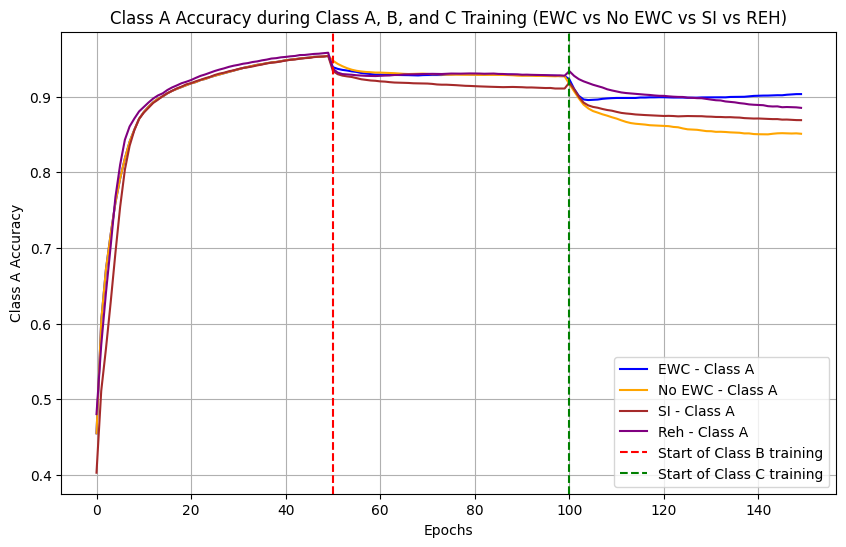

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean for Task A during Task A and Task B across all runs
ewc_initial_acc = np.mean(epoch_stats["ewc"]["A_during_A_val"], axis=0)  # Mean across runs
no_ewc_initial_acc = np.mean(epoch_stats["ewc"]["A_during_A_val"], axis=0)  # Same for No EWC
#pnn_A_during_A = np.mean(epoch_stats_other["pnn"]["A_during_A_val"], axis=0) # Same for pnn
si_A_during_A = np.mean(epoch_stats_other["si"]["A_during_A_val"], axis=0) # Same for si
reh_A_during_A = np.mean(filtered_reh["reh"]["A_during_A_val"], axis=0) # Same for reh

# Now for Task A accuracy during Task B training
ewc_task_A_during_B = np.mean(epoch_stats["ewc"]["A_during_B_val"], axis=0)  # Average over runs
no_ewc_task_A_during_B = np.mean(epoch_stats_no_ewc["no_ewc"]["A_during_B_val"], axis=0)  # Same for No EWC
#pnn_task_A_during_B = np.mean(epoch_stats_other["pnn"]["task_A_during_B"],axis=0) # Same for pnn
si_task_A_during_B = np.mean(epoch_stats_other["si"]["val_task_A_during_B"],axis=0) # Same for si
reh_task_A_during_B = np.mean(filtered_reh["reh"]["val_task_A_during_B"],axis=0) # Same for reh

# Now for Task A accuracy during Task C training
ewc_task_A_during_C = np.mean(epoch_stats["ewc"]["A_during_C_val"], axis=0)  # Average over runs
no_ewc_task_A_during_C = np.mean(epoch_stats_no_ewc["no_ewc"]["A_during_C_val"], axis=0)  # Same for No EWC
#pnn_task_A_during_C = np.mean(epoch_stats_other["pnn"]["task_A_during_C"],axis=0) # Same for pnn
si_task_A_during_C = np.mean(epoch_stats_other["si"]["task_A_during_C"],axis=0) # Same for si
reh_task_A_during_C = np.mean(filtered_reh["reh"]["task_A_during_C"],axis=0) # Same for reh

# Concatenate the Task A accuracy during Task A and Task B phases
ewc_task_A_combined = np.concatenate([ewc_initial_acc, ewc_task_A_during_B,ewc_task_A_during_C])
no_ewc_task_A_combined = np.concatenate([no_ewc_initial_acc, no_ewc_task_A_during_B,no_ewc_task_A_during_C])
#pnn_task_A_combined = np.concatenate([pnn_A_during_A, pnn_task_A_during_B,pnn_task_A_during_C])
si_task_A_combined = np.concatenate([si_A_during_A, si_task_A_during_B,si_task_A_during_C])
reh_task_A_combined = np.concatenate([reh_A_during_A, reh_task_A_during_B,reh_task_A_during_C])

# X-axis: first half for Task A training, second half for Task B training
total_epochs = len(ewc_task_A_combined)
x_values = np.arange(total_epochs)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, ewc_task_A_combined, label='EWC - Class A', color='blue')
plt.plot(x_values, no_ewc_task_A_combined, label='No EWC - Class A', color='orange')
#plt.plot(x_values, pnn_task_A_combined, label='PNN - Class A', color='green')
plt.plot(x_values, si_task_A_combined, label='SI - Class A', color='brown')
plt.plot(x_values, reh_task_A_combined, label='Reh - Class A', color='purple')

# Mark the point where Task B training begins
plt.axvline(x=len(ewc_initial_acc), color='red', linestyle='--', label='Start of Class B training')
plt.axvline(x=len(ewc_initial_acc) + len(ewc_task_A_during_B), color='green', linestyle='--', label='Start of Class C training')


# Labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Class A Accuracy')
plt.title('Class A Accuracy during Class A, B, and C Training (EWC vs No EWC vs SI vs REH)')
plt.legend()
plt.grid(True)

# Save and show the plot
#plt.savefig('cil_bench_accuracy_plot_taskA.png')
plt.show()


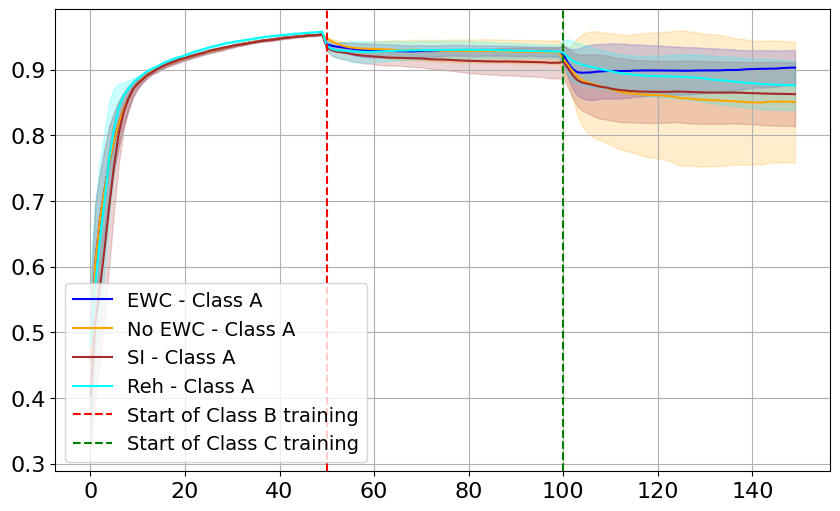

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Compute the mean and standard deviation for Task A during Class A training
ewc_initial_acc = np.mean(epoch_stats["ewc"]["A_during_A_val"], axis=0)
ewc_initial_acc_std = np.std(epoch_stats["ewc"]["A_during_A_val"], axis=0)

no_ewc_initial_acc = np.mean(epoch_stats["ewc"]["A_during_A_val"], axis=0)
no_ewc_initial_acc_std = np.std(epoch_stats["ewc"]["A_during_A_val"], axis=0)

si_A_during_A = np.mean(epoch_stats_other["si"]["A_during_A_val"], axis=0)
si_A_during_A_std = np.std(epoch_stats_other["si"]["A_during_A_val"], axis=0)

reh_A_during_A = np.mean(filtered_reh["reh"]["A_during_A_val"], axis=0)
reh_A_during_A_std = np.std(filtered_reh["reh"]["A_during_A_val"], axis=0)

# Compute the mean and standard deviation for Task A during Class B training
ewc_task_A_during_B = np.mean(epoch_stats["ewc"]["A_during_B_val"], axis=0)
ewc_task_A_during_B_std = np.std(epoch_stats["ewc"]["A_during_B_val"], axis=0)

no_ewc_task_A_during_B = np.mean(epoch_stats_no_ewc["no_ewc"]["A_during_B_val"], axis=0)
no_ewc_task_A_during_B_std = np.std(epoch_stats_no_ewc["no_ewc"]["A_during_B_val"], axis=0)

si_task_A_during_B = np.mean(epoch_stats_other["si"]["val_task_A_during_B"], axis=0)
si_task_A_during_B_std = np.std(epoch_stats_other["si"]["val_task_A_during_B"], axis=0)

reh_task_A_during_B = np.mean(filtered_reh["reh"]["val_task_A_during_B"], axis=0)
reh_task_A_during_B_std = np.std(filtered_reh["reh"]["val_task_A_during_B"], axis=0)

# Compute the mean and standard deviation for Task A during Class C training
ewc_task_A_during_C = np.mean(epoch_stats["ewc"]["A_during_C_val"], axis=0)
ewc_task_A_during_C_std = np.std(epoch_stats["ewc"]["A_during_C_val"], axis=0)

no_ewc_task_A_during_C = np.mean(epoch_stats_no_ewc["no_ewc"]["A_during_C_val"], axis=0)
no_ewc_task_A_during_C_std = np.std(epoch_stats_no_ewc["no_ewc"]["A_during_C_val"], axis=0)

si_task_A_during_C = np.mean(epoch_stats_other["si"]["val_task_A_during_C"], axis=0)
si_task_A_during_C_std = np.std(epoch_stats_other["si"]["val_task_A_during_C"], axis=0)

reh_task_A_during_C = np.mean(filtered_reh["reh"]["val_task_A_during_C"], axis=0)
reh_task_A_during_C_std = np.std(filtered_reh["reh"]["val_task_A_during_C"], axis=0)

# Concatenate mean and standard deviation for all phases
ewc_task_A_combined = np.concatenate([ewc_initial_acc, ewc_task_A_during_B, ewc_task_A_during_C])
ewc_task_A_combined_std = np.concatenate([ewc_initial_acc_std, ewc_task_A_during_B_std, ewc_task_A_during_C_std])

no_ewc_task_A_combined = np.concatenate([no_ewc_initial_acc, no_ewc_task_A_during_B, no_ewc_task_A_during_C])
no_ewc_task_A_combined_std = np.concatenate([no_ewc_initial_acc_std, no_ewc_task_A_during_B_std, no_ewc_task_A_during_C_std])

si_task_A_combined = np.concatenate([si_A_during_A, si_task_A_during_B, si_task_A_during_C])
si_task_A_combined_std = np.concatenate([si_A_during_A_std, si_task_A_during_B_std, si_task_A_during_C_std])

reh_task_A_combined = np.concatenate([reh_A_during_A, reh_task_A_during_B, reh_task_A_during_C])
reh_task_A_combined_std = np.concatenate([reh_A_during_A_std, reh_task_A_during_B_std, reh_task_A_during_C_std])

# Define x-axis
total_epochs = len(ewc_task_A_combined)
x_values = np.arange(total_epochs)

# Plot with variance bands
plt.figure(figsize=(10, 6))

plt.plot(x_values, ewc_task_A_combined, label='EWC - Class A', color='blue')
plt.fill_between(x_values, ewc_task_A_combined - ewc_task_A_combined_std, ewc_task_A_combined + ewc_task_A_combined_std, color='blue', alpha=0.2)

plt.plot(x_values, no_ewc_task_A_combined, label='No EWC - Class A', color='orange')
plt.fill_between(x_values, no_ewc_task_A_combined - no_ewc_task_A_combined_std, no_ewc_task_A_combined + no_ewc_task_A_combined_std, color='orange', alpha=0.2)

plt.plot(x_values, si_task_A_combined, label='SI - Class A', color='brown')
plt.fill_between(x_values, si_task_A_combined - si_task_A_combined_std, si_task_A_combined + si_task_A_combined_std, color='brown', alpha=0.2)

plt.plot(x_values, reh_task_A_combined, label='Reh - Class A', color='cyan')
plt.fill_between(x_values, reh_task_A_combined - reh_task_A_combined_std, reh_task_A_combined + reh_task_A_combined_std, color='cyan', alpha=0.2)

# Mark the transition points
plt.axvline(x=len(ewc_initial_acc), color='red', linestyle='--', label='Start of Class B training')
plt.axvline(x=len(ewc_initial_acc) + len(ewc_task_A_during_B), color='green', linestyle='--', label='Start of Class C training')

# Labels, title, and legend
plt.xticks(fontsize=16)                 # Font size for x-axis ticks
plt.yticks(fontsize=16) 
plt.legend(loc='lower left',fontsize=14)
plt.grid(True)

# Save and show the plot
plt.savefig('cil_bench_accuracy_plot_taskA_with_variance_bigger.png')
plt.show()


In [282]:
np.mean(epoch_stats["ewc"]["B_during_A_val"], axis=0)

array([0.31720023, 0.32703725, 0.35005821, 0.3637369 , 0.37037253,
       0.36976135, 0.36717113, 0.3637369 , 0.35838184, 0.35430733,
       0.3523865 , 0.35165891, 0.35130966, 0.34994179, 0.34941793,
       0.34906868, 0.34842841, 0.34729336, 0.34560536, 0.34481956,
       0.34336438, 0.34284051, 0.34121071, 0.34001746, 0.33850407,
       0.3371362 , 0.33716531, 0.33667055, 0.33553551, 0.33399302,
       0.33314901, 0.33218859, 0.33204307, 0.33096624, 0.32927823,
       0.32814319, 0.32694994, 0.32689173, 0.32654249, 0.325844  ,
       0.32491269, 0.32508731, 0.32433062, 0.32389406, 0.32383586,
       0.32307916, 0.3233702 , 0.32284633, 0.3225553 , 0.32264261])

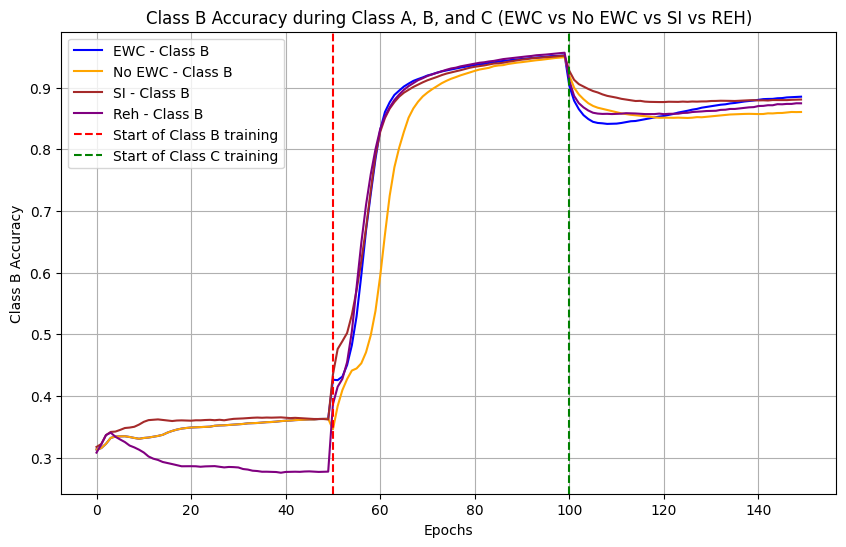

In [108]:
# Calculate the mean for Task B during Task C
B_ewc_initial_acc = np.mean(epoch_stats["ewc"]["val_task_B"], axis=0)  # Mean across runs
B_no_ewc_initial_acc = np.mean(epoch_stats_no_ewc["no_ewc"]["val_task_B"], axis=0)  # Mean across runs

pnn_task_B = np.mean(epoch_stats_other["pnn"]["val_task_B"], axis=0) # Mean across runs
si_task_B = np.mean(epoch_stats_other["si"]["val_task_B"], axis=0) # Mean across runs
reh_task_B = np.mean(filtered_reh["reh"]["val_task_B"], axis=0) # Mean across runs

# Now for Task A accuracy during Task B training
ewc_task_B_during_C = np.mean(epoch_stats["ewc"]["B_during_C_val"], axis=0)  # Average over runs
no_ewc_task_B_during_C = np.mean(epoch_stats_no_ewc["no_ewc"]["B_during_C_val"], axis=0)  # Same for No EWC
#pnn_task_B_during_C = np.mean(epoch_stats_other["pnn"]["val_task_B_during_C"], axis=0) # Same for pnn
si_task_B_during_C = np.mean(epoch_stats_other["si"]["val_task_B_during_C"], axis=0) # Same for si
reh_task_B_during_C = np.mean(filtered_reh["reh"]["val_task_B_during_C"], axis=0) # Same for reh

# Now for Task A accuracy during Task B training
ewc_task_B_during_A = np.mean(epoch_stats["ewc"]["B_during_A_val"], axis=0)  # Average over runs
no_ewc_task_B_during_A = np.mean(epoch_stats["ewc"]["B_during_A_val"], axis=0)  # Same for No EWC
#pnn_task_B_during_A = np.mean(epoch_stats_other["pnn"]["val_task_B_during_A"], axis=0) # Same for pnn
si_task_B_during_A = np.mean(epoch_stats_other["si"]["B_during_A_val"], axis=0) # Same for si
reh_task_B_during_A = np.mean(filtered_reh["reh"]["B_during_A_val"], axis=0) # Same for reh

# Concatenate the Task A accuracy during Task A and Task B phases
ewc_task_B_combined = np.concatenate([ewc_task_B_during_A,B_ewc_initial_acc, ewc_task_B_during_C])
no_ewc_task_B_combined = np.concatenate([no_ewc_task_B_during_A,B_no_ewc_initial_acc, no_ewc_task_B_during_C])
#pnn_task_B_combined = np.concatenate([pnn_task_B_during_A,pnn_task_B,pnn_task_B_during_C])
si_task_B_combined = np.concatenate([si_task_B_during_A,si_task_B,si_task_B_during_C])
reh_task_B_combined = np.concatenate([reh_task_B_during_A,reh_task_B,reh_task_B_during_C])

# X-axis: first half for Task A training, second half for Task B training
total_epochs = len(ewc_task_B_combined)
x_values = np.arange(total_epochs)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, ewc_task_B_combined, label='EWC - Class B', color='blue')
plt.plot(x_values, no_ewc_task_B_combined, label='No EWC - Class B', color='orange')
#plt.plot(x_values, pnn_task_B_combined, label='PNN - Class B', color='green')
plt.plot(x_values, si_task_B_combined, label='SI - Class B', color='brown')
plt.plot(x_values, reh_task_B_combined, label='Reh - Class B', color='purple')

# Mark the point where Task B training begins
plt.axvline(x=len(ewc_initial_acc), color='red', linestyle='--', label='Start of Class B training')
plt.axvline(x=len(ewc_initial_acc) + len(ewc_task_A_during_B), color='green', linestyle='--', label='Start of Class C training')

# Labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Class B Accuracy')
plt.title('Class B Accuracy during Class A, B, and C (EWC vs No EWC vs SI vs REH)')
plt.legend()
plt.grid(True)

# Save and show the plot
plt.savefig('cil_bench_accuracy_plot_taskB.png')
plt.show()


In [290]:
no_ewc_task_B_combined

array([0.31720023, 0.32703725, 0.35005821, 0.3637369 , 0.37037253,
       0.36976135, 0.36717113, 0.3637369 , 0.35838184, 0.35430733,
       0.3523865 , 0.35165891, 0.35130966, 0.34994179, 0.34941793,
       0.34906868, 0.34842841, 0.34729336, 0.34560536, 0.34481956,
       0.34336438, 0.34284051, 0.34121071, 0.34001746, 0.33850407,
       0.3371362 , 0.33716531, 0.33667055, 0.33553551, 0.33399302,
       0.33314901, 0.33218859, 0.33204307, 0.33096624, 0.32927823,
       0.32814319, 0.32694994, 0.32689173, 0.32654249, 0.325844  ,
       0.32491269, 0.32508731, 0.32433062, 0.32389406, 0.32383586,
       0.32307916, 0.3233702 , 0.32284633, 0.3225553 , 0.32264261,
       0.3459837 , 0.38364377, 0.40963329, 0.42753201, 0.44126892,
       0.44467404, 0.45299767, 0.47092549, 0.49845751, 0.53803842,
       0.59464494, 0.66181607, 0.72453434, 0.77092549, 0.80229919,
       0.82811409, 0.85122235, 0.86618161, 0.87709546, 0.88573923,
       0.89205471, 0.89749709, 0.9023865 , 0.90713038, 0.91100

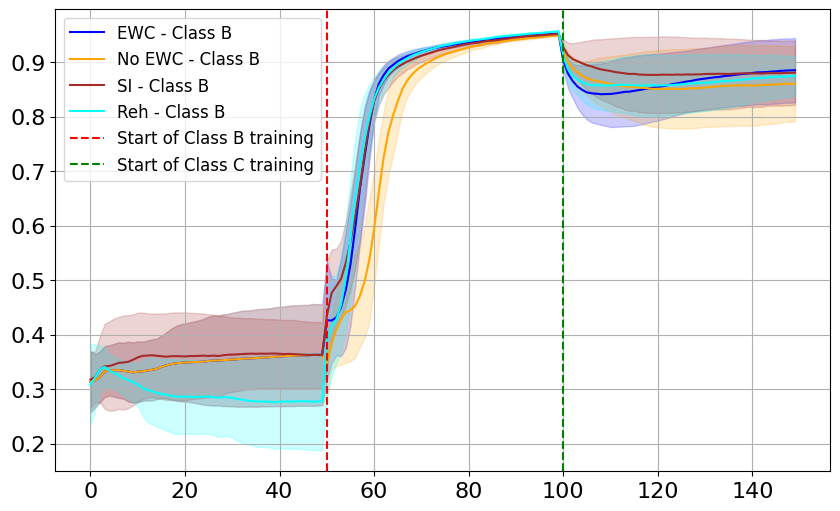

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Compute the mean and standard deviation for Class B during Class B training
B_ewc_initial_acc = np.mean(epoch_stats["ewc"]["val_task_B"], axis=0)
B_ewc_initial_acc_std = np.std(epoch_stats["ewc"]["val_task_B"], axis=0)

B_no_ewc_initial_acc = np.mean(epoch_stats_no_ewc["no_ewc"]["val_task_B"], axis=0)
B_no_ewc_initial_acc_std = np.std(epoch_stats_no_ewc["no_ewc"]["val_task_B"], axis=0)

si_task_B = np.mean(epoch_stats_other["si"]["val_task_B"], axis=0)
si_task_B_std = np.std(epoch_stats_other["si"]["val_task_B"], axis=0)

reh_task_B = np.mean(filtered_reh["reh"]["val_task_B"], axis=0)
reh_task_B_std = np.std(filtered_reh["reh"]["val_task_B"], axis=0)

# Compute the mean and standard deviation for Class B during Class C training
ewc_task_B_during_C = np.mean(epoch_stats["ewc"]["B_during_C_val"], axis=0)
ewc_task_B_during_C_std = np.std(epoch_stats["ewc"]["B_during_C_val"], axis=0)

no_ewc_task_B_during_C = np.mean(epoch_stats_no_ewc["no_ewc"]["B_during_C_val"], axis=0)
no_ewc_task_B_during_C_std = np.std(epoch_stats_no_ewc["no_ewc"]["B_during_C_val"], axis=0)

si_task_B_during_C = np.mean(epoch_stats_other["si"]["val_task_B_during_C"], axis=0)
si_task_B_during_C_std = np.std(epoch_stats_other["si"]["val_task_B_during_C"], axis=0)

reh_task_B_during_C = np.mean(filtered_reh["reh"]["val_task_B_during_C"], axis=0)
reh_task_B_during_C_std = np.std(filtered_reh["reh"]["val_task_B_during_C"], axis=0)

# Compute the mean and standard deviation for Class B during Class A training
ewc_task_B_during_A = np.mean(epoch_stats["ewc"]["B_during_A_val"], axis=0)
ewc_task_B_during_A_std = np.std(epoch_stats["ewc"]["B_during_A_val"], axis=0)

no_ewc_task_B_during_A = np.mean(epoch_stats_no_ewc["no_ewc"]["B_during_A_val"], axis=0)
no_ewc_task_B_during_A_std = np.std(epoch_stats_no_ewc["no_ewc"]["B_during_A_val"], axis=0)

si_task_B_during_A = np.mean(epoch_stats_other["si"]["B_during_A_val"], axis=0)
si_task_B_during_A_std = np.std(epoch_stats_other["si"]["B_during_A_val"], axis=0)

reh_task_B_during_A = np.mean(filtered_reh["reh"]["B_during_A_val"], axis=0)
reh_task_B_during_A_std = np.std(filtered_reh["reh"]["B_during_A_val"], axis=0)

# Concatenate mean and standard deviation for all phases
ewc_task_B_combined = np.concatenate([ewc_task_B_during_A, B_ewc_initial_acc, ewc_task_B_during_C])
ewc_task_B_combined_std = np.concatenate([ewc_task_B_during_A_std, B_ewc_initial_acc_std, ewc_task_B_during_C_std])

no_ewc_task_B_combined = np.concatenate([ewc_task_B_during_A, B_no_ewc_initial_acc, no_ewc_task_B_during_C])
no_ewc_task_B_combined_std = np.concatenate([ewc_task_B_during_A_std, B_no_ewc_initial_acc_std, no_ewc_task_B_during_C_std])

si_task_B_combined = np.concatenate([si_task_B_during_A, si_task_B, si_task_B_during_C])
si_task_B_combined_std = np.concatenate([si_task_B_during_A_std, si_task_B_std, si_task_B_during_C_std])

reh_task_B_combined = np.concatenate([reh_task_B_during_A, reh_task_B, reh_task_B_during_C])
reh_task_B_combined_std = np.concatenate([reh_task_B_during_A_std, reh_task_B_std, reh_task_B_during_C_std])

# Define x-axis
total_epochs = len(ewc_task_B_combined)
x_values = np.arange(total_epochs)

# Plot with variance bands
plt.figure(figsize=(10, 6))

plt.plot(x_values, ewc_task_B_combined, label='EWC - Class B', color='blue')
plt.fill_between(x_values, ewc_task_B_combined - ewc_task_B_combined_std, ewc_task_B_combined + ewc_task_B_combined_std, color='blue', alpha=0.2)

plt.plot(x_values, no_ewc_task_B_combined, label='No EWC - Class B', color='orange')
plt.fill_between(x_values, no_ewc_task_B_combined - no_ewc_task_B_combined_std, no_ewc_task_B_combined + no_ewc_task_B_combined_std, color='orange', alpha=0.2)

plt.plot(x_values, si_task_B_combined, label='SI - Class B', color='brown')
plt.fill_between(x_values, si_task_B_combined - si_task_B_combined_std, si_task_B_combined + si_task_B_combined_std, color='brown', alpha=0.2)

plt.plot(x_values, reh_task_B_combined, label='Reh - Class B', color='cyan')
plt.fill_between(x_values, reh_task_B_combined - reh_task_B_combined_std, reh_task_B_combined + reh_task_B_combined_std, color='cyan', alpha=0.2)

# Mark the transition points
plt.axvline(x=len(ewc_task_B_during_A), color='red', linestyle='--', label='Start of Class B training')
plt.axvline(x=len(ewc_task_B_during_A) + len(B_ewc_initial_acc), color='green', linestyle='--', label='Start of Class C training')

# Labels, title, and legend
plt.xticks(fontsize=16)                 # Font size for x-axis ticks
plt.yticks(fontsize=16) 
plt.legend(loc='upper left',fontsize=12)
plt.grid(True)

# Save and show the plot
plt.savefig('cil_bench_accuracy_plot_taskB_with_variance_bigger.png')
plt.show()


In [298]:
no_ewc_task_B_combined = np.concatenate([no_ewc_task_B_during_A, B_no_ewc_initial_acc, no_ewc_task_B_during_C])

In [307]:
no_ewc_task_B_during_A

nan

In [62]:
epoch_stats_other["si"]["val_task_C"]

[[0.3110988098533075,
  0.31165236645447,
  0.3119291447550512,
  0.3119291447550512,
  0.3119291447550512,
  0.31165236645447,
  0.31220592305563244,
  0.31220592305563244,
  0.31220592305563244,
  0.3127594796567949,
  0.3127594796567949,
  0.31331303625795737,
  0.31331303625795737,
  0.31331303625795737,
  0.3135898145585386,
  0.3141433711597011,
  0.31497370606144476,
  0.3158040409631885,
  0.31608081926376974,
  0.3169111541655134,
  0.3169111541655134,
  0.3169111541655134,
  0.31718793246609467,
  0.31718793246609467,
  0.3166343758649322,
  0.3169111541655134,
  0.31774148906725713,
  0.31774148906725713,
  0.3182950456684196,
  0.3182950456684196,
  0.31857182396900086,
  0.31884860226958206,
  0.32050927207306945,
  0.31884860226958206,
  0.3194021588707445,
  0.32050927207306945,
  0.3196789371713258,
  0.3207860503736507,
  0.3221699418765569,
  0.3221699418765569,
  0.3221699418765569,
  0.3221699418765569,
  0.32300027677830057,
  0.32300027677830057,
  0.3232770550788

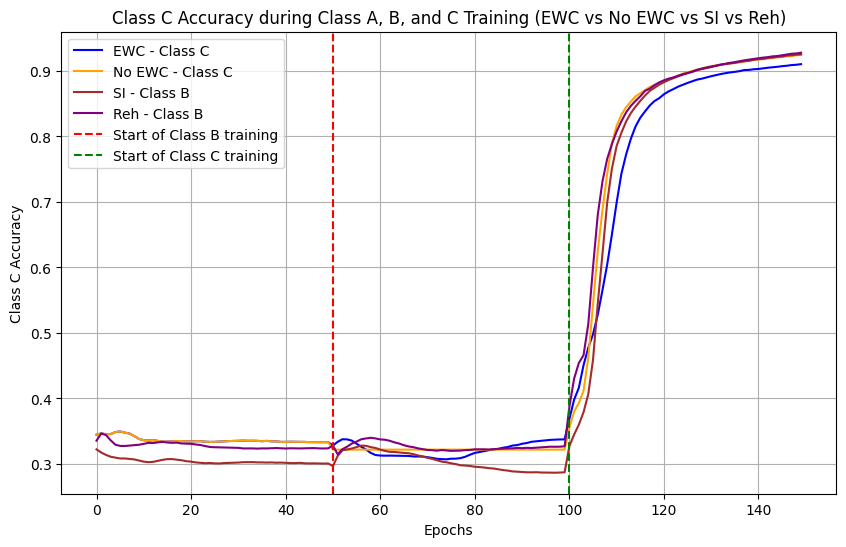

In [46]:
import matplotlib.pyplot as plt
# Calculate the mean for Task A during Class B and Task B across all runs
ewc_B_during_A = np.mean(epoch_stats["ewc"]["C_during_A_val"], axis=0)  # Mean across runs
no_ewc_B_during_A = np.mean(epoch_stats["ewc"]["C_during_A_val"], axis=0)  # Same for No EWC
#pnn_B_during_A = np.mean(epoch_stats_other["pnn"]["B_during_A_val"], axis=0) # Same for pnn
si_B_during_A = np.mean(epoch_stats_other["si"]["C_during_A_val"], axis=0) # Same for si
reh_B_during_A = np.mean(filtered_reh["C_during_A_val"], axis=0) # Same for reh

# Now Task B training
ewc_task_B = np.mean(epoch_stats["ewc"]["C_during_B_val"], axis=0)  # Average over runs
no_ewc_task_B = np.mean(epoch_stats_no_ewc["no_ewc"]["C_during_B_val"], axis=0)  # Same for No EWC
#pnn_task_B = np.mean(epoch_stats_other["pnn"]["val_task_B"],axis=0) # Same for pnn
si_task_B = np.mean(epoch_stats_other["si"]["C_during_B_val"],axis=0) # Same for si
reh_task_B = np.mean(filtered_reh["C_during_B_val"],axis=0) # Same for reh

# Now for Class B accuracy during Task C training
ewc_task_B_during_C = np.mean(epoch_stats["ewc"]["val_task_C"], axis=0)  # Average over runs
no_ewc_task_B_during_C = np.mean(epoch_stats_no_ewc["no_ewc"]["val_task_C"], axis=0)  # Same for No EWC
#pnn_task_B_during_C = np.mean(epoch_stats_other["pnn"]["task_B_during_C"],axis=0) # Same for pnn
si_task_B_during_C = np.mean(epoch_stats_other["si"]["val_task_C"],axis=0) # Same for si
reh_task_B_during_C = np.mean(filtered_reh["val_task_C"],axis=0) # Same for reh


# Concatenate the Class B accuracy during Class B and Task B phases
ewc_task_A_combined = np.concatenate([ewc_B_during_A, ewc_task_B, ewc_task_B_during_C])
no_ewc_task_A_combined = np.concatenate([no_ewc_B_during_A,no_ewc_task_B, no_ewc_task_B_during_C])
#pnn_task_A_combined = np.concatenate([pnn_B_during_A,pnn_task_B, pnn_task_B_during_C])
si_task_A_combined = np.concatenate([si_B_during_A,si_task_B, si_task_B_during_C])
reh_task_A_combined = np.concatenate([reh_B_during_A,reh_task_B, reh_task_B_during_C])

# X-axis: first half for Class B training, second half for Task B training
total_epochs = len(ewc_task_A_combined)
x_values = np.arange(total_epochs)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, ewc_task_A_combined, label='EWC - Class C', color='blue')
plt.plot(x_values, no_ewc_task_A_combined, label='No EWC - Class C', color='orange')
#plt.plot(x_values, pnn_task_A_combined, label='PNN - Class B', color='green')
plt.plot(x_values, si_task_A_combined, label='SI - Class B', color='brown')
plt.plot(x_values, reh_task_A_combined, label='Reh - Class B', color='purple')

# Mark the point where Task B training begins
plt.axvline(x=len(ewc_initial_acc), color='red', linestyle='--', label='Start of Class B training')
plt.axvline(x=len(ewc_initial_acc) + len(ewc_task_A_during_B), color='green', linestyle='--', label='Start of Class C training')


# Labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Class C Accuracy')
plt.title('Class C Accuracy during Class A, B, and C Training (EWC vs No EWC vs SI vs Reh)')
plt.legend()
plt.grid(True)

# Save and show the plot
plt.savefig('cil_bench_accuracy_plot_taskC.png')
plt.show()


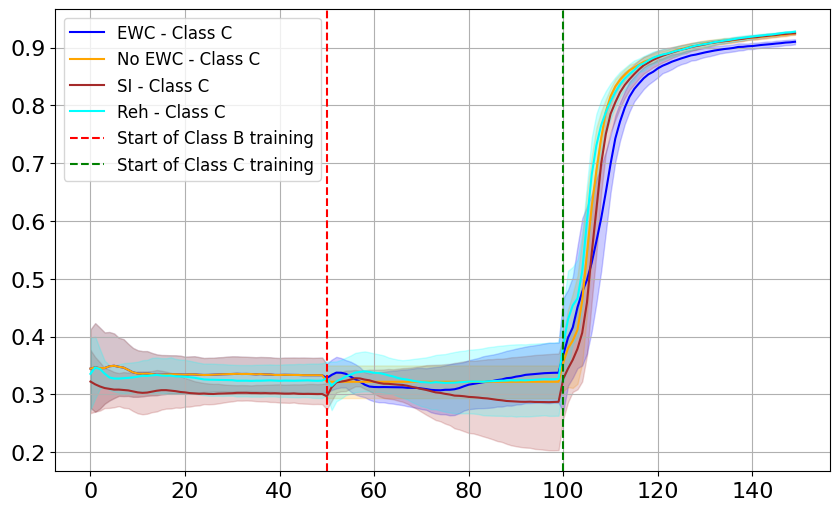

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Compute the mean and standard deviation for Class C during Class A training
ewc_B_during_A = np.mean(epoch_stats["ewc"]["C_during_A_val"], axis=0)
ewc_B_during_A_std = np.std(epoch_stats["ewc"]["C_during_A_val"], axis=0)

no_ewc_B_during_A = np.mean(epoch_stats["ewc"]["C_during_A_val"], axis=0)
no_ewc_B_during_A_std = np.std(epoch_stats["ewc"]["C_during_A_val"], axis=0)

si_B_during_A = np.mean(epoch_stats_other["si"]["C_during_A_val"], axis=0)
si_B_during_A_std = np.std(epoch_stats_other["si"]["C_during_A_val"], axis=0)

reh_B_during_A = np.mean(filtered_reh["reh"]["C_during_A_val"], axis=0)
reh_B_during_A_std = np.std(filtered_reh["reh"]["C_during_A_val"], axis=0)

# Compute the mean and standard deviation for Class C during Class B training
ewc_task_B = np.mean(epoch_stats["ewc"]["C_during_B_val"], axis=0)
ewc_task_B_std = np.std(epoch_stats["ewc"]["C_during_B_val"], axis=0)

no_ewc_task_B = np.mean(epoch_stats_no_ewc["no_ewc"]["C_during_B_val"], axis=0)
no_ewc_task_B_std = np.std(epoch_stats_no_ewc["no_ewc"]["C_during_B_val"], axis=0)

si_task_B = np.mean(epoch_stats_other["si"]["C_during_B_val"], axis=0)
si_task_B_std = np.std(epoch_stats_other["si"]["C_during_B_val"], axis=0)

reh_task_B = np.mean(filtered_reh["reh"]["C_during_B_val"], axis=0)
reh_task_B_std = np.std(filtered_reh["reh"]["C_during_B_val"], axis=0)

# Compute the mean and standard deviation for Class C during Class C training
ewc_task_B_during_C = np.mean(epoch_stats["ewc"]["val_task_C"], axis=0)
ewc_task_B_during_C_std = np.std(epoch_stats["ewc"]["val_task_C"], axis=0)

no_ewc_task_B_during_C = np.mean(epoch_stats_no_ewc["no_ewc"]["val_task_C"], axis=0)
no_ewc_task_B_during_C_std = np.std(epoch_stats_no_ewc["no_ewc"]["val_task_C"], axis=0)

si_task_B_during_C = np.mean(epoch_stats_other["si"]["val_task_C"], axis=0)
si_task_B_during_C_std = np.std(epoch_stats_other["si"]["val_task_C"], axis=0)

reh_task_B_during_C = np.mean(filtered_reh["reh"]["val_task_C"], axis=0)
reh_task_B_during_C_std = np.std(filtered_reh["reh"]["val_task_C"], axis=0)

# Concatenate mean and standard deviation for all phases
ewc_task_A_combined = np.concatenate([ewc_B_during_A, ewc_task_B, ewc_task_B_during_C])
ewc_task_A_combined_std = np.concatenate([ewc_B_during_A_std, ewc_task_B_std, ewc_task_B_during_C_std])

no_ewc_task_A_combined = np.concatenate([no_ewc_B_during_A, no_ewc_task_B, no_ewc_task_B_during_C])
no_ewc_task_A_combined_std = np.concatenate([no_ewc_B_during_A_std, no_ewc_task_B_std, no_ewc_task_B_during_C_std])

si_task_A_combined = np.concatenate([si_B_during_A, si_task_B, si_task_B_during_C])
si_task_A_combined_std = np.concatenate([si_B_during_A_std, si_task_B_std, si_task_B_during_C_std])

reh_task_A_combined = np.concatenate([reh_B_during_A, reh_task_B, reh_task_B_during_C])
reh_task_A_combined_std = np.concatenate([reh_B_during_A_std, reh_task_B_std, reh_task_B_during_C_std])

# Define x-axis
total_epochs = len(ewc_task_A_combined)
x_values = np.arange(total_epochs)

# Plot with variance bands
plt.figure(figsize=(10, 6))

plt.plot(x_values, ewc_task_A_combined, label='EWC - Class C', color='blue')
plt.fill_between(x_values, ewc_task_A_combined - ewc_task_A_combined_std, ewc_task_A_combined + ewc_task_A_combined_std, color='blue', alpha=0.2)

plt.plot(x_values, no_ewc_task_A_combined, label='No EWC - Class C', color='orange')
plt.fill_between(x_values, no_ewc_task_A_combined - no_ewc_task_A_combined_std, no_ewc_task_A_combined + no_ewc_task_A_combined_std, color='orange', alpha=0.2)

plt.plot(x_values, si_task_A_combined, label='SI - Class C', color='brown')
plt.fill_between(x_values, si_task_A_combined - si_task_A_combined_std, si_task_A_combined + si_task_A_combined_std, color='brown', alpha=0.2)

plt.plot(x_values, reh_task_A_combined, label='Reh - Class C', color='cyan')
plt.fill_between(x_values, reh_task_A_combined - reh_task_A_combined_std, reh_task_A_combined + reh_task_A_combined_std, color='cyan', alpha=0.2)

# Mark the transition points
plt.axvline(x=len(ewc_B_during_A), color='red', linestyle='--', label='Start of Class B training')
plt.axvline(x=len(ewc_B_during_A) + len(ewc_task_B), color='green', linestyle='--', label='Start of Class C training')

# Labels, title, and legend
plt.xticks(fontsize=16)                 # Font size for x-axis ticks
plt.yticks(fontsize=16) 
plt.legend(loc='upper left',fontsize=12)
plt.grid(True)

# Save and show the plot
plt.savefig('cil_bench_accuracy_plot_taskC_with_variance_bigger.png')
plt.show()


In [31]:
filtered_reh = {"reh": filtered_reh}

In [106]:
epoch_stats_other["si"]["val_task_A_during_B"]

[[0.936969696969697,
  0.9347474747474748,
  0.9333333333333333,
  0.9327272727272727,
  0.9288888888888889,
  0.9242424242424242,
  0.9212121212121213,
  0.9177777777777778,
  0.9133333333333333,
  0.9123232323232323,
  0.9096969696969697,
  0.9086868686868687,
  0.907070707070707,
  0.9052525252525252,
  0.9046464646464647,
  0.9044444444444445,
  0.9042424242424243,
  0.9028282828282829,
  0.9024242424242425,
  0.9024242424242425,
  0.902020202020202,
  0.9016161616161616,
  0.901010101010101,
  0.9,
  0.9004040404040404,
  0.9018181818181819,
  0.9026262626262627,
  0.9016161616161616,
  0.9014141414141414,
  0.9016161616161616,
  0.9006060606060606,
  0.9004040404040404,
  0.9,
  0.8993939393939394,
  0.8985858585858586,
  0.8987878787878788,
  0.8977777777777778,
  0.8981818181818182,
  0.8983838383838384,
  0.897979797979798,
  0.8975757575757576,
  0.8977777777777778,
  0.8983838383838384,
  0.8983838383838384,
  0.8975757575757576,
  0.8977777777777778,
  0.8981818181818182,
 

In [35]:
# Extract data directly from dictionaries without modifying their original structure
import pandas as pd
# Helper function to calculate max, min, and mean for final epoch from a dictionary
def calculate_final_epoch_stats_with_bounds(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    final_epoch_data = data[:, -1]  # Extract the last column (final epoch values)
    
    mean_final = np.mean(final_epoch_data)  # Mean of the final epoch
    max_final = np.max(final_epoch_data)  # Max of the final epoch
    min_final = np.min(final_epoch_data)  # Min of the final epoch
    std_final = np.std(final_epoch_data)  # Standard deviation
    upper_bound = mean_final + 2 * std_final  # 2 standard deviations above mean
    lower_bound = mean_final - 2 * std_final  # 2 standard deviations below mean
    
    return mean_final, max_final, min_final, upper_bound, lower_bound

# epoch_stats
# epoch_stats_other
# filtered_reh
# epoch_stats_no_ewc

# Average of the final epoch for Task A during Task A training
avg_final_epoch_task_A_A_ewc = np.mean(np.array(epoch_stats["ewc"]["A_during_A_val"])[:, -1])
avg_final_epoch_task_A_A = np.mean(np.array(epoch_stats["ewc"]["A_during_A_val"])[:, -1])
avg_final_epoch_task_A_A_si = np.mean(np.array(epoch_stats_other["si"]["A_during_A_val"])[:, -1])
avg_final_epoch_task_A_A_reh = np.mean(np.array(filtered_reh["reh"]["A_during_A_val"])[:, -1])

# Updating Task A after Class B
ewc_stats_after_B = calculate_final_epoch_stats_with_bounds(epoch_stats["ewc"], "A_during_B_val")
no_ewc_stats_after_B = calculate_final_epoch_stats_with_bounds(epoch_stats_no_ewc["no_ewc"], "A_during_B_val")
si_stats_after_B = calculate_final_epoch_stats_with_bounds(epoch_stats_other["si"], "val_task_A_during_B")
reh_stats_after_B = calculate_final_epoch_stats_with_bounds(filtered_reh["reh"], "val_task_A_during_B")

# Updating Task A after Class C
ewc_stats_after_C = calculate_final_epoch_stats_with_bounds(epoch_stats["ewc"], "A_during_C_val")
no_ewc_stats_after_C = calculate_final_epoch_stats_with_bounds(epoch_stats_no_ewc["no_ewc"], "A_during_C_val")
si_stats_after_C = calculate_final_epoch_stats_with_bounds(epoch_stats_other["si"], "val_task_A_during_C")
reh_stats_after_C = calculate_final_epoch_stats_with_bounds(filtered_reh["reh"], "val_task_A_during_C")

# Create summary table for Task A after Class B
final_epoch_summary = pd.DataFrame({
    "Method": ["EWC", "No EWC", "SI", "Rehearsal"],
    "Class A After A": [avg_final_epoch_task_A_A_ewc, avg_final_epoch_task_A_A_ewc, avg_final_epoch_task_A_A_si, avg_final_epoch_task_A_A_reh],
    "Mean Acc After B": [ewc_stats_after_B[0], no_ewc_stats_after_B[0], si_stats_after_B[0], reh_stats_after_B[0]],
    "Max Acc After B": [ewc_stats_after_B[1], no_ewc_stats_after_B[1], si_stats_after_B[1], reh_stats_after_B[1]],
    "Min Acc After B": [ewc_stats_after_B[2], no_ewc_stats_after_B[2], si_stats_after_B[2], reh_stats_after_B[2]],
    "Upper Bound (Mean + 2SD)": [ewc_stats_after_B[3], no_ewc_stats_after_B[3], si_stats_after_B[3], reh_stats_after_B[3]],
    "Lower Bound (Mean - 2SD)": [ewc_stats_after_B[4], no_ewc_stats_after_B[4], si_stats_after_B[4], reh_stats_after_B[4]]
})

# Create summary table for Task A after Class C
final_epoch_summary_after_C = pd.DataFrame({
    "Method": ["EWC", "No EWC", "SI", "Rehearsal"],
    "Class A After A": [avg_final_epoch_task_A_A_ewc, avg_final_epoch_task_A_A_ewc, avg_final_epoch_task_A_A_si, avg_final_epoch_task_A_A_reh],
    "Mean Acc After C": [ewc_stats_after_C[0], no_ewc_stats_after_C[0], si_stats_after_C[0], reh_stats_after_C[0]],
    "Max Acc After C": [ewc_stats_after_C[1], no_ewc_stats_after_C[1], si_stats_after_C[1], reh_stats_after_C[1]],
    "Min Acc After C": [ewc_stats_after_C[2], no_ewc_stats_after_C[2], si_stats_after_C[2], reh_stats_after_C[2]],
    "Upper Bound (Mean + 2SD)": [ewc_stats_after_C[3], no_ewc_stats_after_C[3], si_stats_after_C[3], reh_stats_after_C[3]],
    "Lower Bound (Mean - 2SD)": [ewc_stats_after_C[4], no_ewc_stats_after_C[4], si_stats_after_C[4], reh_stats_after_C[4]]
})


# Display results
# Display results using print for both tables


print("Class A Performance After Training on Class A and After Class B")
print(final_epoch_summary)

print("\nClass A Performance After Training on Class A, B and C")
print(final_epoch_summary_after_C)





Class A Performance After Training on Class A and After Class B
      Method  Class A After A  Mean Acc After B  Max Acc After B  \
0        EWC         0.953919          0.927192         0.938182   
1     No EWC         0.953919          0.926727         0.952121   
2         SI         0.953616          0.910646         0.934545   
3  Rehearsal         0.957980          0.927596         0.945051   

   Min Acc After B  Upper Bound (Mean + 2SD)  Lower Bound (Mean - 2SD)  
0         0.914141                  0.941247                  0.913137  
1         0.895556                  0.963047                  0.890408  
2         0.846667                  0.958547                  0.862746  
3         0.905657                  0.947172                  0.908020  

Class A Performance After Training on Class A, B and C
      Method  Class A After A  Mean Acc After C  Max Acc After C  \
0        EWC         0.953919          0.903293         0.941212   
1     No EWC         0.953919         

In [39]:
# Extract data directly from dictionaries without modifying their original structure
import pandas as pd
# Helper function to calculate max, min, and mean for final epoch from a dictionary
def calculate_final_epoch_stats_from_dict(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    max_final = np.max(data[:, -1])  # Max of the final epoch
    min_final = np.min(data[:, -1])  # Min of the final epoch
    mean_final = np.mean(data[:, -1])  # Mean of the final epoch
    return max_final, min_final, mean_final

# epoch_stats
# epoch_stats_other
# filtered_reh
# epoch_stats_no_ewc

# Average of the final epoch for Task A during Task A training
avg_final_epoch_task_B_ewc = np.mean(np.array(epoch_stats["ewc"]["val_task_B"])[:, -1])
avg_final_epoch_task_B = np.mean(np.array(epoch_stats_no_ewc["no_ewc"]["val_task_B"])[:, -1])
avg_final_epoch_task_B_si = np.mean(np.array(epoch_stats_other["si"]["val_task_B"])[:, -1])
avg_final_epoch_task_B_reh = np.mean(np.array(filtered_reh["reh"]["val_task_B"])[:, -1])

def calculate_final_epoch_stats_with_bounds(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    final_epoch_data = data[:, -1]  # Extract the last column (final epoch values)
    
    mean_final = np.mean(final_epoch_data)  # Mean of the final epoch
    max_final = np.max(final_epoch_data)  # Max of the final epoch
    min_final = np.min(final_epoch_data)  # Min of the final epoch
    std_final = np.std(final_epoch_data)  # Standard deviation
    upper_bound = mean_final + 2 * std_final  # 2 standard deviations above mean
    lower_bound = mean_final - 2 * std_final  # 2 standard deviations below mean
    
    return mean_final, max_final, min_final, upper_bound, lower_bound

# Calculating statistics with bounds for Class B after C
ewc_stats_B_after_C = calculate_final_epoch_stats_with_bounds(epoch_stats["ewc"], "B_during_C_val")
no_ewc_stats_B_after_C = calculate_final_epoch_stats_with_bounds(epoch_stats_no_ewc["no_ewc"], "B_during_C_val")
si_stats_B_after_C = calculate_final_epoch_stats_with_bounds(epoch_stats_other["si"], "val_task_B_during_C")
reh_stats_B_after_C = calculate_final_epoch_stats_with_bounds(filtered_reh["reh"], "val_task_B_during_C")

# Creating a summary table for Class B after C with bounds
final_epoch_summary_B_after_C = pd.DataFrame({
    "Method": ["EWC", "No EWC", "SI", "Rehearsal"],
    "Class B After B": [avg_final_epoch_task_B_ewc, avg_final_epoch_task_B, avg_final_epoch_task_B_si, avg_final_epoch_task_B_reh],
    "Mean Acc After C": [ewc_stats_B_after_C[0], no_ewc_stats_B_after_C[0], si_stats_B_after_C[0], reh_stats_B_after_C[0]],
    "Max Acc After C": [ewc_stats_B_after_C[1], no_ewc_stats_B_after_C[1], si_stats_B_after_C[1], reh_stats_B_after_C[1]],
    "Min Acc After C": [ewc_stats_B_after_C[2], no_ewc_stats_B_after_C[2], si_stats_B_after_C[2], reh_stats_B_after_C[2]],
    "Upper Bound (Mean + 2SD)": [ewc_stats_B_after_C[3], no_ewc_stats_B_after_C[3], si_stats_B_after_C[3], reh_stats_B_after_C[3]],
    "Lower Bound (Mean - 2SD)": [ewc_stats_B_after_C[4], no_ewc_stats_B_after_C[4], si_stats_B_after_C[4], reh_stats_B_after_C[4]]
})
# Display results
# Display results using print for both tables


print("Class B Performance After Training on Class B and After Class C")
print(final_epoch_summary_B_after_C)




Class B Performance After Training on Class B and After Class C
      Method  Class B After B  Mean Acc After C  Max Acc After C  \
0        EWC         0.952299          0.885274         0.938009   
1     No EWC         0.949447          0.860477         0.926077   
2         SI         0.951775          0.880704         0.941793   
3  Rehearsal         0.956577          0.874563         0.922293   

   Min Acc After C  Upper Bound (Mean + 2SD)  Lower Bound (Mean - 2SD)  
0         0.750291                  1.003319                  0.767228  
1         0.694121                  0.999273                  0.721681  
2         0.760768                  0.998997                  0.762412  
3         0.797439                  0.947213                  0.801914  


In [40]:
# Calculate statistics for the final epoch of Task B during Task B training

# Helper function to calculate mean, max, min, std, and bounds for the final epoch
def calculate_final_epoch_stats_class_C(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    final_epoch_values = data[:, -1]  # Extract values from the last epoch

    mean_final = np.mean(final_epoch_values)  # Mean of the final epoch
    max_final = np.max(final_epoch_values)  # Max of the final epoch
    min_final = np.min(final_epoch_values)  # Min of the final epoch
    std_final = np.std(final_epoch_values)  # Standard deviation of the final epoch

    upper_bound = mean_final + 2 * std_final  # Mean + 2*STD
    lower_bound = mean_final - 2 * std_final  # Mean - 2*STD

    return mean_final, max_final, min_final, std_final, upper_bound, lower_bound

# Calculate stats for each method (including bounds)
class_C_ewc_mean, class_C_ewc_max, class_C_ewc_min, class_C_ewc_std, class_C_ewc_upper, class_C_ewc_lower = calculate_final_epoch_stats_class_C(epoch_stats["ewc"], "val_task_C")
class_C_no_ewc_mean, class_C_no_ewc_max, class_C_no_ewc_min, class_C_no_ewc_std, class_C_no_ewc_upper, class_C_no_ewc_lower = calculate_final_epoch_stats_class_C(epoch_stats_no_ewc["no_ewc"], "val_task_C")
class_C_si_mean, class_C_si_max, class_C_si_min, class_C_si_std, class_C_si_upper, class_C_si_lower = calculate_final_epoch_stats_class_C(epoch_stats_other["si"], "val_task_C")
class_C_reh_mean, class_C_reh_max, class_C_reh_min, class_C_reh_std, class_C_reh_upper, class_C_reh_lower = calculate_final_epoch_stats_class_C(epoch_stats_other["reh"], "val_task_C")

# Create a summary table for Task C training (including bounds)
final_epoch_task_C_summary = pd.DataFrame({
    "Method": ["EWC", "No EWC", "SI", "Rehearsal"],
    "Mean Final Acc": [class_C_ewc_mean, class_C_no_ewc_mean, class_C_si_mean, class_C_reh_mean],
    "Max Final Acc": [class_C_ewc_max, class_C_no_ewc_max, class_C_si_max, class_C_reh_max],
    "Min Final Acc": [class_C_ewc_min, class_C_no_ewc_min, class_C_si_min, class_C_reh_min],
    "Upper Bound (Mean + 2*STD)": [class_C_ewc_upper, class_C_no_ewc_upper, class_C_si_upper, class_C_reh_upper],
    "Lower Bound (Mean - 2*STD)": [class_C_ewc_lower, class_C_no_ewc_lower, class_C_si_lower, class_C_reh_lower]
})

# Display results for Task B
print("Final Accuracy for Class C")
print(final_epoch_task_C_summary)


Final Accuracy for Class C
      Method  Mean Final Acc  Max Final Acc  Min Final Acc  \
0        EWC        0.910324       0.917243       0.903128   
1     No EWC        0.924882       0.929145       0.919181   
2         SI        0.925131       0.930252       0.921118   
3  Rehearsal        0.958137       0.990590       0.924163   

   Upper Bound (Mean + 2*STD)  Lower Bound (Mean - 2*STD)  
0                    0.919097                    0.901550  
1                    0.929933                    0.919832  
2                    0.930078                    0.920185  
3                    1.019008                    0.897266  


In [115]:
# Calculate statistics for the final epoch of Task B during Task B training

# Helper function to calculate mean, max, and min for the final epoch
def calculate_final_epoch_stats_class_B(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    mean_final = np.mean(data[:, -1])  # Mean of the final epoch
    max_final = np.max(data[:, -1])  # Max of the final epoch
    min_final = np.min(data[:, -1])  # Min of the final epoch
    return mean_final, max_final, min_final

# Calculate stats for each method
class_B_ewc_mean, class_B_ewc_max, class_B_ewc_min = calculate_final_epoch_stats_class_B(epoch_stats["ewc"], "val_task_B")
class_B_no_ewc_mean, class_B_no_ewc_max, class_B_no_ewc_min = calculate_final_epoch_stats_class_B(epoch_stats_no_ewc["no_ewc"], "val_task_B")
class_B_si_mean, class_B_si_max, class_B_si_min = calculate_final_epoch_stats_class_B(epoch_stats_other["si"], "val_task_B")
class_B_reh_mean, class_B_reh_max, class_B_reh_min = calculate_final_epoch_stats_class_B(epoch_stats_other["reh"], "val_task_B")

# Create a summary table for Task B during Task B training
final_epoch_task_B_summary = pd.DataFrame({
    "Method": ["EWC", "No EWC", "SI", "Rehearsal"],
    "Mean Final Acc": [class_B_ewc_mean, class_B_no_ewc_mean, class_B_si_mean, class_B_reh_mean],
    "Max Final Acc": [class_B_ewc_max, class_B_no_ewc_max, class_B_si_max, class_B_reh_max],
    "Min Final Acc": [class_B_ewc_min, class_B_no_ewc_min, class_B_si_min, class_B_reh_min]
})

# Display results for Task B
print("Final Accuracy for Class B")
print(final_epoch_task_B_summary)


Final Accuracy for Class B
      Method  Mean Final Acc  Max Final Acc  Min Final Acc
0        EWC        0.952299       0.956345       0.947322
1     No EWC        0.949447       0.951688       0.946449
2         SI        0.951775       0.956054       0.947905
3  Rehearsal        0.974447       0.993015       0.952852


In [15]:
def train_with_l2(model, optimizer, dataloaders, criterion, lambda_l2, epochs=1):
    """Train model using L2 regularization (weight decay)."""
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for data, target in dataloaders['train']:
            data, target = data.float(), target.long()  # Ensure proper dtype
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)  # BCE or CrossEntropy Loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloaders['train']):.4f}")


In [27]:
# Initialize dictionary for storing L2 experiment results
epoch_stats_other["l2"] = {
    "A_during_A": [], "B_during_A": [], "C_during_A": [], "C_during_B": [],
    "A_during_A_val": [], "B_during_A_val": [], "C_during_A_val": [], "C_during_B_val": [],
    "task_A_during_B": [], "task_B": [], "task_C": [],
    "val_task_A_during_B": [], "val_task_B": [], "val_task_C": [],
    "task_A_during_C": [], "task_B_during_C": [],
    "val_task_A_during_C": [], "val_task_B_during_C": []
}

num_runs = 1
epochs = 50
learning_rate = 0.000001
lambda_l2 = 0.01  # L2 regularization strength

for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")

    # Initialize model, optimizer, and criterion for L2
    model_l2 = SimpleNN()  
    optimizer_l2 = optim.Adam(model_l2.parameters(), lr=learning_rate, weight_decay=lambda_l2)
    criterion = nn.CrossEntropyLoss()

    A_during_A, B_during_A, C_during_A, C_during_B = [], [], [], []
    A_during_A_val, B_during_A_val, C_during_A_val, C_during_B_val = [], [], [], []

    print("Training on Digits 0-3 with L2")
    for epoch in range(epochs):
        train_with_l2(model_l2, optimizer_l2, {'train': train_loader_1, 'val': val_loader_1}, criterion, lambda_l2, epochs=1)

        # Evaluate accuracy for task performance tracking
        A_during_A.append(evaluate(model_l2, test_loader_1, criterion, initial_classes)[0])
        B_during_A.append(evaluate(model_l2, test_loader_2, criterion, subsequent_classes)[0])
        C_during_A.append(evaluate(model_l2, test_loader_3, criterion, final_classes)[0])

        A_during_A_val.append(evaluate(model_l2, val_loader_1, criterion, initial_classes)[0])
        B_during_A_val.append(evaluate(model_l2, val_loader_2, criterion, subsequent_classes)[0])
        C_during_A_val.append(evaluate(model_l2, val_loader_3, criterion, final_classes)[0])

    epoch_stats_other["l2"]["A_during_A"].append(A_during_A)
    epoch_stats_other["l2"]["B_during_A"].append(B_during_A)
    epoch_stats_other["l2"]["C_during_A"].append(C_during_A)
    epoch_stats_other["l2"]["A_during_A_val"].append(A_during_A_val)
    epoch_stats_other["l2"]["B_during_A_val"].append(B_during_A_val)
    epoch_stats_other["l2"]["C_during_A_val"].append(C_during_A_val)

    # Train on Digits 4-6 (Task B)
    print("Training on Digits 4-6 with L2")
    task_A_during_B_l2_run, task_B_l2_run, val_A_during_B_l2_run, val_B_l2_run = [], [], [], []
    for epoch in range(epochs):
        train_with_l2(model_l2, optimizer_l2, {'train': train_loader_2, 'val': val_loader_2}, criterion, lambda_l2, epochs=1)

        # Evaluate performance
        task_B_l2_run.append(evaluate(model_l2, test_loader_2, criterion, subsequent_classes)[0])
        task_A_during_B_l2_run.append(evaluate(model_l2, test_loader_1, criterion, initial_classes)[0])
        C_during_B.append(evaluate(model_l2, test_loader_3, criterion, final_classes)[0])

        val_B_l2_run.append(evaluate(model_l2, val_loader_2, criterion, subsequent_classes)[0])
        val_A_during_B_l2_run.append(evaluate(model_l2, val_loader_1, criterion, initial_classes)[0])
        C_during_B_val.append(evaluate(model_l2, val_loader_3, criterion, final_classes)[0])

    epoch_stats_other["l2"]["task_A_during_B"].append(task_A_during_B_l2_run)
    epoch_stats_other["l2"]["task_B"].append(task_B_l2_run)
    epoch_stats_other["l2"]["val_task_A_during_B"].append(val_A_during_B_l2_run)
    epoch_stats_other["l2"]["val_task_B"].append(val_B_l2_run)
    epoch_stats_other["l2"]["C_during_B"].append(C_during_B)
    epoch_stats_other["l2"]["C_during_B_val"].append(C_during_B_val)

    # Train on Digits 7-9 (Task C)
    print("Training on Digits 7-9 with L2")
    task_A_during_C_l2_run, task_B_during_C_l2_run, task_C_l2_run = [], [], []
    val_A_during_C_l2_run, val_B_during_C_l2_run, val_C_l2_run = [], [], []
    for epoch in range(epochs):
        train_with_l2(model_l2, optimizer_l2, {'train': train_loader_3, 'val': val_loader_3}, criterion, lambda_l2, epochs=1)

        # Evaluate performance
        task_C_l2_run.append(evaluate(model_l2, test_loader_3, criterion, final_classes)[0])
        task_A_during_C_l2_run.append(evaluate(model_l2, test_loader_1, criterion, initial_classes)[0])
        task_B_during_C_l2_run.append(evaluate(model_l2, test_loader_2, criterion, subsequent_classes)[0])

        val_C_l2_run.append(evaluate(model_l2, val_loader_3, criterion, final_classes)[0])
        val_A_during_C_l2_run.append(evaluate(model_l2, val_loader_1, criterion, initial_classes)[0])
        val_B_during_C_l2_run.append(evaluate(model_l2, val_loader_2, criterion, subsequent_classes)[0])

    epoch_stats_other["l2"]["task_A_during_C"].append(task_A_during_C_l2_run)
    epoch_stats_other["l2"]["task_B_during_C"].append(task_B_during_C_l2_run)
    epoch_stats_other["l2"]["task_C"].append(task_C_l2_run)
    epoch_stats_other["l2"]["val_task_A_during_C"].append(val_A_during_C_l2_run)
    epoch_stats_other["l2"]["val_task_B_during_C"].append(val_B_during_C_l2_run)
    epoch_stats_other["l2"]["val_task_C"].append(val_C_l2_run)

    print(f"Final Performance on Task C with L2: {evaluate(model_l2, test_loader_3, criterion, final_classes)}")
    print(f"Final Performance on Task B with L2: {evaluate(model_l2, test_loader_2, criterion, subsequent_classes)}")
    print(f"Final Performance on Task A with L2: {evaluate(model_l2, test_loader_1, criterion, initial_classes)}")

Run 1/1
Training on Digits 0-3 with L2
Epoch 1/1, Loss: 2.2089
Epoch 1/1, Loss: 2.0497
Epoch 1/1, Loss: 1.8826
Epoch 1/1, Loss: 1.7156
Epoch 1/1, Loss: 1.5596
Epoch 1/1, Loss: 1.4202
Epoch 1/1, Loss: 1.2991
Epoch 1/1, Loss: 1.1942
Epoch 1/1, Loss: 1.1038
Epoch 1/1, Loss: 1.0246
Epoch 1/1, Loss: 0.9530
Epoch 1/1, Loss: 0.8877
Epoch 1/1, Loss: 0.8292
Epoch 1/1, Loss: 0.7762
Epoch 1/1, Loss: 0.7280
Epoch 1/1, Loss: 0.6838
Epoch 1/1, Loss: 0.6433
Epoch 1/1, Loss: 0.6057
Epoch 1/1, Loss: 0.5706
Epoch 1/1, Loss: 0.5387
Epoch 1/1, Loss: 0.5089
Epoch 1/1, Loss: 0.4818
Epoch 1/1, Loss: 0.4564
Epoch 1/1, Loss: 0.4333
Epoch 1/1, Loss: 0.4122
Epoch 1/1, Loss: 0.3924
Epoch 1/1, Loss: 0.3740
Epoch 1/1, Loss: 0.3573
Epoch 1/1, Loss: 0.3419
Epoch 1/1, Loss: 0.3279
Epoch 1/1, Loss: 0.3149
Epoch 1/1, Loss: 0.3029
Epoch 1/1, Loss: 0.2917
Epoch 1/1, Loss: 0.2811
Epoch 1/1, Loss: 0.2716
Epoch 1/1, Loss: 0.2629
Epoch 1/1, Loss: 0.2547
Epoch 1/1, Loss: 0.2473
Epoch 1/1, Loss: 0.2402
Epoch 1/1, Loss: 0.2338
E

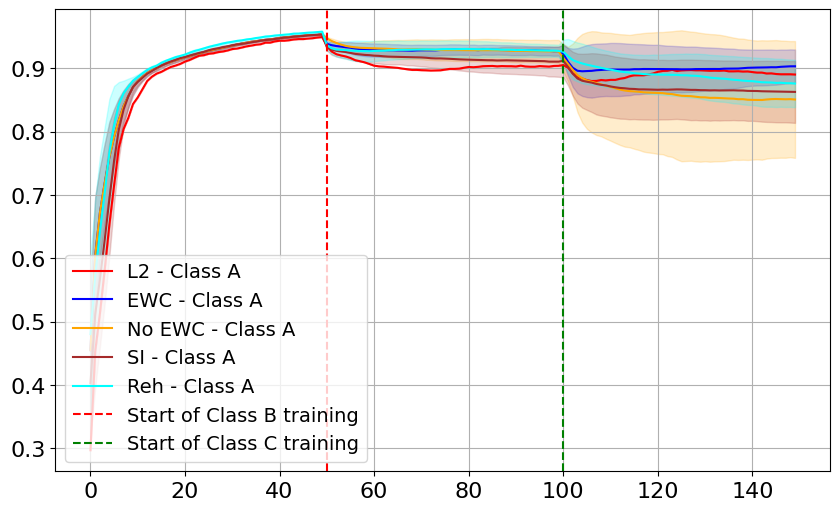

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Compute the mean and standard deviation for Task A during Class A training
l2_initial_acc = np.mean(epoch_stats_other["l2"]["A_during_A_val"], axis=0)
l2_initial_acc_std = np.std(epoch_stats_other["l2"]["A_during_A_val"], axis=0)

ewc_initial_acc = np.mean(epoch_stats["ewc"]["A_during_A_val"], axis=0)
ewc_initial_acc_std = np.std(epoch_stats["ewc"]["A_during_A_val"], axis=0)

no_ewc_initial_acc = np.mean(epoch_stats["ewc"]["A_during_A_val"], axis=0)
no_ewc_initial_acc_std = np.std(epoch_stats["ewc"]["A_during_A_val"], axis=0)

si_A_during_A = np.mean(epoch_stats_other["si"]["A_during_A_val"], axis=0)
si_A_during_A_std = np.std(epoch_stats_other["si"]["A_during_A_val"], axis=0)

reh_A_during_A = np.mean(filtered_reh["reh"]["A_during_A_val"], axis=0)
reh_A_during_A_std = np.std(filtered_reh["reh"]["A_during_A_val"], axis=0)

# Compute the mean and standard deviation for Task A during Class B training
l2_task_A_during_B = np.mean(epoch_stats_other["l2"]["val_task_A_during_B"], axis=0)
l2_task_A_during_B_std = np.std(epoch_stats_other["l2"]["val_task_A_during_B"], axis=0)

ewc_task_A_during_B = np.mean(epoch_stats["ewc"]["A_during_B_val"], axis=0)
ewc_task_A_during_B_std = np.std(epoch_stats["ewc"]["A_during_B_val"], axis=0)

no_ewc_task_A_during_B = np.mean(epoch_stats_no_ewc["no_ewc"]["A_during_B_val"], axis=0)
no_ewc_task_A_during_B_std = np.std(epoch_stats_no_ewc["no_ewc"]["A_during_B_val"], axis=0)

si_task_A_during_B = np.mean(epoch_stats_other["si"]["val_task_A_during_B"], axis=0)
si_task_A_during_B_std = np.std(epoch_stats_other["si"]["val_task_A_during_B"], axis=0)

reh_task_A_during_B = np.mean(filtered_reh["reh"]["val_task_A_during_B"], axis=0)
reh_task_A_during_B_std = np.std(filtered_reh["reh"]["val_task_A_during_B"], axis=0)

# Compute the mean and standard deviation for Task A during Class C training
l2_task_A_during_C = np.mean(epoch_stats_other["l2"]["val_task_A_during_C"], axis=0)
l2_task_A_during_C_std = np.std(epoch_stats_other["l2"]["val_task_A_during_C"], axis=0)

ewc_task_A_during_C = np.mean(epoch_stats["ewc"]["A_during_C_val"], axis=0)
ewc_task_A_during_C_std = np.std(epoch_stats["ewc"]["A_during_C_val"], axis=0)

no_ewc_task_A_during_C = np.mean(epoch_stats_no_ewc["no_ewc"]["A_during_C_val"], axis=0)
no_ewc_task_A_during_C_std = np.std(epoch_stats_no_ewc["no_ewc"]["A_during_C_val"], axis=0)

si_task_A_during_C = np.mean(epoch_stats_other["si"]["val_task_A_during_C"], axis=0)
si_task_A_during_C_std = np.std(epoch_stats_other["si"]["val_task_A_during_C"], axis=0)

reh_task_A_during_C = np.mean(filtered_reh["reh"]["val_task_A_during_C"], axis=0)
reh_task_A_during_C_std = np.std(filtered_reh["reh"]["val_task_A_during_C"], axis=0)

# Concatenate mean and standard deviation for all phases
l2_task_A_combined = np.concatenate([l2_initial_acc, l2_task_A_during_B, l2_task_A_during_C])
l2_task_A_combined_std = np.concatenate([l2_initial_acc_std, l2_task_A_during_B_std, l2_task_A_during_C_std])

ewc_task_A_combined = np.concatenate([ewc_initial_acc, ewc_task_A_during_B, ewc_task_A_during_C])
ewc_task_A_combined_std = np.concatenate([ewc_initial_acc_std, ewc_task_A_during_B_std, ewc_task_A_during_C_std])

no_ewc_task_A_combined = np.concatenate([no_ewc_initial_acc, no_ewc_task_A_during_B, no_ewc_task_A_during_C])
no_ewc_task_A_combined_std = np.concatenate([no_ewc_initial_acc_std, no_ewc_task_A_during_B_std, no_ewc_task_A_during_C_std])

si_task_A_combined = np.concatenate([si_A_during_A, si_task_A_during_B, si_task_A_during_C])
si_task_A_combined_std = np.concatenate([si_A_during_A_std, si_task_A_during_B_std, si_task_A_during_C_std])

reh_task_A_combined = np.concatenate([reh_A_during_A, reh_task_A_during_B, reh_task_A_during_C])
reh_task_A_combined_std = np.concatenate([reh_A_during_A_std, reh_task_A_during_B_std, reh_task_A_during_C_std])

# Define x-axis
total_epochs = len(l2_task_A_combined)
x_values = np.arange(total_epochs)

# Plot with variance bands
plt.figure(figsize=(10, 6))

plt.plot(x_values, l2_task_A_combined, label='L2 - Class A', color='red')
plt.fill_between(x_values, l2_task_A_combined - l2_task_A_combined_std, l2_task_A_combined + l2_task_A_combined_std, color='red', alpha=0.2)

plt.plot(x_values, ewc_task_A_combined, label='EWC - Class A', color='blue')
plt.fill_between(x_values, ewc_task_A_combined - ewc_task_A_combined_std, ewc_task_A_combined + ewc_task_A_combined_std, color='blue', alpha=0.2)

plt.plot(x_values, no_ewc_task_A_combined, label='No EWC - Class A', color='orange')
plt.fill_between(x_values, no_ewc_task_A_combined - no_ewc_task_A_combined_std, no_ewc_task_A_combined + no_ewc_task_A_combined_std, color='orange', alpha=0.2)

plt.plot(x_values, si_task_A_combined, label='SI - Class A', color='brown')
plt.fill_between(x_values, si_task_A_combined - si_task_A_combined_std, si_task_A_combined + si_task_A_combined_std, color='brown', alpha=0.2)

plt.plot(x_values, reh_task_A_combined, label='Reh - Class A', color='cyan')
plt.fill_between(x_values, reh_task_A_combined - reh_task_A_combined_std, reh_task_A_combined + reh_task_A_combined_std, color='cyan', alpha=0.2)

# Mark the transition points
plt.axvline(x=len(l2_initial_acc), color='red', linestyle='--', label='Start of Class B training')
plt.axvline(x=len(l2_initial_acc) + len(l2_task_A_during_B), color='green', linestyle='--', label='Start of Class C training')

# Labels, title, and legend
plt.xticks(fontsize=16)                 # Font size for x-axis ticks
plt.yticks(fontsize=16) 
plt.legend(loc='lower left',fontsize=14)
plt.grid(True)

# Save and show the plot
#plt.savefig('cil_bench_accuracy_plot_taskA_with_L2_variance.png')
plt.show()


In [ ]:
filtered_reh